<a href="https://colab.research.google.com/github/arbi11/CEFC-2022/blob/main/Inflection_Point_Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from skimage.feature import peak_local_max
from imblearn.over_sampling import SMOTE
from time import time

Good to know what version of tensorflow we're using...

In [ ]:
print(tf.version.VERSION)

2.8.2


# Data Acquisition and Cleanup

In [ ]:
for (name, (train_url, test_url)) in {
    'M6': ('https://docs.google.com/spreadsheets/d/e/2PACX-1vStmjk37Gyxo04Jh_cR0yu-My4Y2KfiXRzNqI9iztS1V5ezxepehbmQOYSNDsao3Sxrksxr5kH0NqBg/pub?gid=405256803&single=true&output=csv',
            'https://docs.google.com/spreadsheets/d/e/2PACX-1vTCx2G0k-SUnmQxg_9TuW-o-D5Z44itWiciuHIkbGXxHPjEPBxbRVP2TMdN7GxRQtkMkkUBUv_IrLXr/pub?gid=1464939435&single=true&output=csv'),
    'M19': ('https://docs.google.com/spreadsheets/d/e/2PACX-1vTX1O03TCJYomYg1QU6SpGi-OhR_V3Kkx1Xkc2JUpaWaLlztDSLMn6eFXyFmaVZrmRIJjGoqY5LkENP/pub?gid=1103714291&single=true&output=csv',
            'https://docs.google.com/spreadsheets/d/e/2PACX-1vQQFzZz0My7iSpzHtl2K2m-2oBCHT--nqaXZiPxct4sJO2CPQWiRD6HRA8AeJHHQkY6bcu9lxatiLaP/pub?gid=1992106649&single=true&output=csv'),
    'M27': ('https://docs.google.com/spreadsheets/d/e/2PACX-1vRdXKEhlJTJJ51CppTioNYQRU7Ehq1ENVg3AeUx62jmkCe8g1miMc7yjcHmqfWyjg3bfJtRoXN77Eb-/pub?gid=635614041&single=true&output=csv',
            'https://docs.google.com/spreadsheets/d/e/2PACX-1vSMECgV6ErVI3a0_8tK6ymGVtvmff_ADVvJ6THlVTv0sL2jn3KAFcTuU04zw2LCmMxPFdY1lEzbi_aB/pub?gid=1533844294&single=true&output=csv'),
    '20PNF1500': ('https://docs.google.com/spreadsheets/d/e/2PACX-1vTBWwGhiUQBhBTGz4DZqAwDaeVxbwxWJDJZpvWQLesTYLDD8ehmMC7OENkgzyohLrCxtcbEKvaABk4Y/pub?gid=1807288876&single=true&output=csv',
                  'https://docs.google.com/spreadsheets/d/e/2PACX-1vSMlA32y9eSewKWs5j3R6FVi5-eQcUhgCzpiLUXlF8adWgScy0lw5-imD6GM0SA_-sHVM8VCtIpYhSP/pub?gid=222833859&single=true&output=csv'),
  }.items():
  print(name)

  # *  Get rid of the 5 useless rows at the beginning of each file
  # *  Normalize the column names to 't', 'Hx', 'Bx', 'Hy', 'By', 'Hz', 'Bz'
  df = pd.read_csv(train_url, skiprows=5, usecols=range(1, 8))
  df.to_csv(f"{name}_train.csv", index=False)
  print(f"  train set: {df.shape}")

  df = pd.read_csv(test_url, skiprows=5, usecols=range(1, 8))
  df.rename(columns={'H x': 'Hx', 'B x': 'Bx', 'H y': 'Hy', 'B y': 'By', 'H z': 'Hz', 'B z': 'Bz'}, inplace=True)
  df.to_csv(f"{name}_test.csv", index=False)
  print(f"  test set:  {df.shape}")

print("\nDone")

M6
  train set: (2001, 7)
  test set:  (11766, 7)
M19
  train set: (2001, 7)
  test set:  (1178, 7)
M27
  train set: (2001, 7)
  test set:  (1178, 7)
20PNF1500
  train set: (2001, 7)
  test set:  (11766, 7)

Done


And the M6 dataset with 20000 data points...

In [ ]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vR4v2LZFBH-tn1nSFUkL8M3cOZSh1I1jQzXsoLyGtdt--hAgyfEYYk087pFB7iatP7FvJsdM9fvfzAG/pub?gid=1926006206&single=true&output=csv',
                 skiprows=5, usecols=range(1, 8))
df.to_csv("M6_train20000.csv", index=False)
print(f"M6 (20000 data point version): {df.shape}")
del df

M6 (20000 data point version): (20001, 7)


# Data Exploration and Visualization

## Utility: Inflection Point

Note that the inflection points are marked with circles

In [ ]:
def find_ip_index(bx):
  v1 = peak_local_max(bx)
  v2 = peak_local_max(-bx)  # find the minimum indices
  return np.unique(np.sort(np.concatenate([v1, v2]).flatten()))

## M6 (2000 data point version)

In [ ]:
df = pd.read_csv('./M6_train.csv')
df

t         Hx        Bx            Hy            By  Hz  \
0       0.0   0.000000  0.000000  0.000000e+00  0.000000e+00   0   
1       0.1   0.005460  0.000075 -1.190000e-17 -2.860000e-17   0   
2       0.2   0.024100  0.000329  1.640000e-14  2.480000e-16   0   
3       0.3   0.042700  0.000584  1.820000e-12 -2.040000e-15   0   
4       0.4   0.061300  0.000839 -2.310000e-14 -3.810000e-14   0   
...     ...        ...       ...           ...           ...  ..   
1996  199.6  26.553186 -0.238842 -4.110000e-10 -2.940000e-11   0   
1997  199.7  27.205196 -0.188133 -3.350000e-10 -2.880000e-11   0   
1998  199.8  27.729051 -0.137423 -2.390000e-10 -1.390000e-11   0   
1999  199.9  28.159743 -0.086700  1.470000e-10 -1.010000e-11   0   
2000  200.0  28.529760 -0.036000  1.970000e-10 -1.290000e-11   0   

                 Bz  
0      0.000000e+00  
1     3.172737e-315  
2     3.172737e-315  
3     3.172737e-315  
4     3.172737e-315  
...             ...  
1996  3.172737e-315  
1997  3.172737e-315  
1998  3.172737e-315  
1999  3.172737e-315  
2000  3.172737e-315  

[2001 rows x 7 columns]

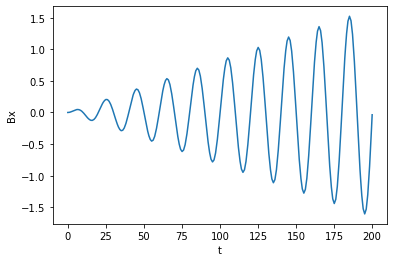

In [ ]:
plt.plot(df['t'], df['Bx'], '-')
plt.xlabel('t')
plt.ylabel('Bx')
plt.show()

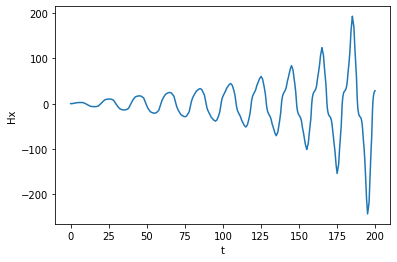

In [ ]:
plt.plot(df['t'], df['Hx'])
plt.xlabel('t')
plt.ylabel('Hx')
plt.show()

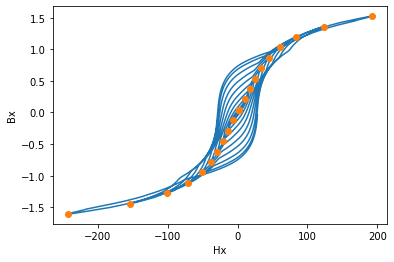

In [ ]:
v = find_ip_index(df['Bx'].to_numpy())
plt.plot(df['Hx'], df['Bx'])
plt.plot(df['Hx'][v], df['Bx'][v], 'o')
plt.xlabel('Hx')
plt.ylabel('Bx')
plt.show()

## M6 (20000 data point version)

In [ ]:
df = pd.read_csv('./M6_train20000.csv')
df

t        Hx        Bx            Hy            By  Hz   Bz
0        0.00  0.000000  0.000000  0.000000e+00  0.000000e+00   0  0.0
1        0.01  0.000546  0.000007 -1.460000e-18  2.090000e-18   0  0.0
2        0.02  0.002410  0.000033  1.020000e-15  3.830000e-17   0  0.0
3        0.03  0.004280  0.000058  5.400000e-15  1.540000e-16   0  0.0
4        0.04  0.006140  0.000084  6.350000e-15  7.590000e-17   0  0.0
...       ...       ...       ...           ...           ...  ..  ...
19996  199.96  7.536977 -0.023900 -1.470000e-09 -6.500000e-11   0  0.0
19997  199.97  7.799354 -0.018800 -1.430000e-09 -6.470000e-11   0  0.0
19998  199.98  8.057725 -0.013800 -1.400000e-09 -6.450000e-11   0  0.0
19999  199.99  8.312216 -0.008700 -1.370000e-09 -6.480000e-11   0  0.0
20000  200.00  8.562948 -0.003630 -1.360000e-09 -6.500000e-11   0  0.0

[20001 rows x 7 columns]

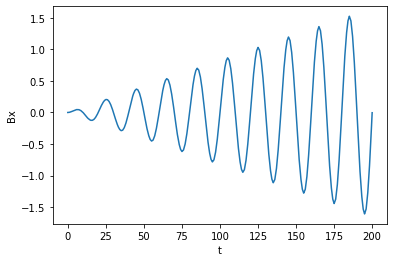

In [ ]:
plt.plot(df['t'], df['Bx'], '-')
plt.xlabel('t')
plt.ylabel('Bx')
plt.show()

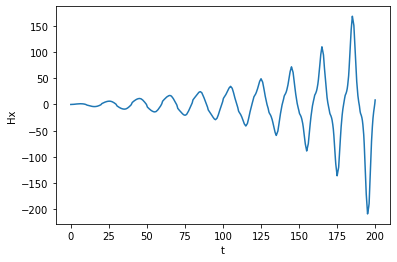

In [ ]:
plt.plot(df['t'], df['Hx'])
plt.xlabel('t')
plt.ylabel('Hx')
plt.show()

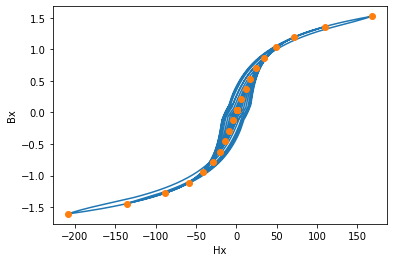

In [ ]:
v = find_ip_index(df['Bx'].to_numpy())
plt.plot(df['Hx'], df['Bx'])
plt.plot(df['Hx'][v], df['Bx'][v], 'o')
plt.xlabel('Hx')
plt.ylabel('Bx')
plt.show()

## M19

In [ ]:
df = pd.read_csv('./M19_train.csv')
df

t         Hx        Bx            Hy            By  Hz  \
0       0.0   0.000000  0.000000  0.000000e+00  0.000000e+00   0   
1       0.1   0.016100  0.000075  4.930000e-18 -4.960000e-18   0   
2       0.2   0.070900  0.000329  1.070000e-14  6.050000e-16   0   
3       0.3   0.125582  0.000584 -6.320000e-12 -1.900000e-14   0   
4       0.4   0.180231  0.000838 -7.490000e-13  7.610000e-15   0   
...     ...        ...       ...           ...           ...  ..   
1996  199.6  54.128872 -0.238981 -4.310000e-10 -1.650000e-11   0   
1997  199.7  55.785869 -0.188277 -6.320000e-10 -1.970000e-11   0   
1998  199.8  56.959727 -0.137570 -7.640000e-10 -1.890000e-11   0   
1999  199.9  57.788775 -0.086900 -6.110000e-10 -1.910000e-11   0   
2000  200.0  58.398845 -0.036200 -4.680000e-10 -1.910000e-11   0   

                 Bz  
0     3.234392e-317  
1     3.231985e-315  
2     3.231985e-315  
3     3.231985e-315  
4     3.231985e-315  
...             ...  
1996  3.231985e-315  
1997  3.231985e-315  
1998  3.231985e-315  
1999  3.231985e-315  
2000  3.231985e-315  

[2001 rows x 7 columns]

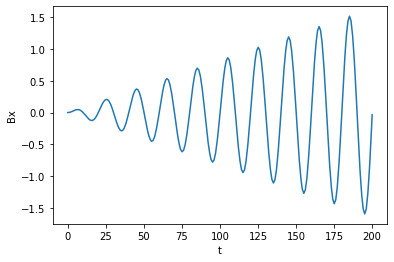

In [ ]:
plt.plot(df['t'], df['Bx'])
plt.xlabel('t')
plt.ylabel('Bx')
plt.show()

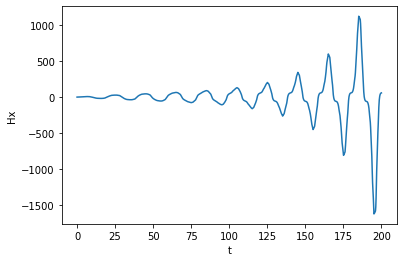

In [ ]:
plt.plot(df['t'], df['Hx'])
plt.xlabel('t')
plt.ylabel('Hx')
plt.show()

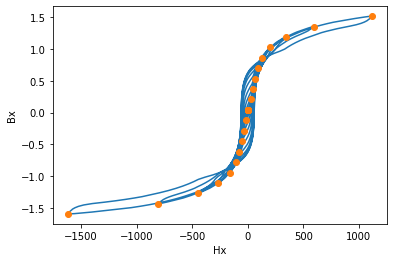

In [ ]:
v = find_ip_index(df['Bx'].to_numpy())
plt.plot(df['Hx'], df['Bx'])
plt.plot(df['Hx'][v], df['Bx'][v], 'o')
plt.xlabel('Hx')
plt.ylabel('Bx')
plt.show()

## M27

In [ ]:
df = pd.read_csv('./M27_train.csv')
df

t         Hx        Bx            Hy            By  Hz  \
0       0.0   0.000000  0.000000  0.000000e+00  0.000000e+00   0   
1       0.1   0.029800  0.000074  5.050000e-17 -1.030000e-17   0   
2       0.2   0.131281  0.000329 -1.940000e-14 -1.540000e-15   0   
3       0.3   0.232548  0.000583  2.660000e-12  5.720000e-16   0   
4       0.4   0.333579  0.000837  1.590000e-12 -3.440000e-16   0   
...     ...        ...       ...           ...           ...  ..   
1996  199.6  83.234273 -0.239127  1.010000e-09  1.200000e-11   0   
1997  199.7  84.088881 -0.188419  2.940000e-10  1.080000e-11   0   
1998  199.8  84.683009 -0.137710  4.460000e-10  1.200000e-11   0   
1999  199.9  85.103368 -0.087000  2.890000e-10  1.200000e-11   0   
2000  200.0  85.431758 -0.036300  2.650000e-10  1.230000e-11   0   

                 Bz  
0      0.000000e+00  
1     3.173707e-315  
2     3.173707e-315  
3     3.173707e-315  
4     3.173707e-315  
...             ...  
1996  3.173707e-315  
1997  3.173707e-315  
1998  3.173707e-315  
1999  3.173707e-315  
2000  3.173707e-315  

[2001 rows x 7 columns]

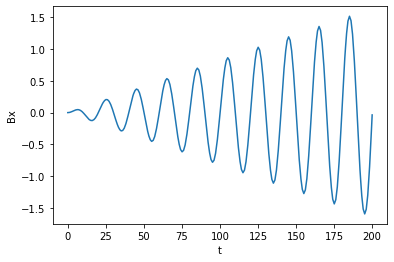

In [ ]:
plt.plot(df['t'], df['Bx'], '-')
plt.xlabel('t')
plt.ylabel('Bx')
plt.show()

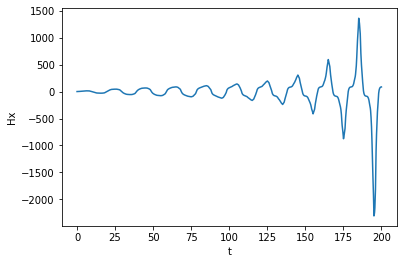

In [ ]:
plt.plot(df['t'], df['Hx'])
plt.xlabel('t')
plt.ylabel('Hx')
plt.show()

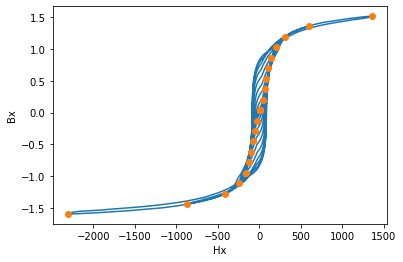

In [ ]:
v = find_ip_index(df['Bx'].to_numpy())
plt.plot(df['Hx'], df['Bx'])
plt.plot(df['Hx'][v], df['Bx'][v], 'o')
plt.xlabel('Hx')
plt.ylabel('Bx')
plt.show()

## 20PNF1500

In [ ]:
df = pd.read_csv('./20PNF1500_train.csv')
df

t         Hx        Bx            Hy            By  Hz  \
0       0.0   0.000000  0.000000  0.000000e+00  0.000000e+00   0   
1       0.1   0.008970  0.000075  2.070000e-18  2.190000e-17   0   
2       0.2   0.039600  0.000329 -2.010000e-14 -8.070000e-16   0   
3       0.3   0.070200  0.000584 -1.240000e-12  1.240000e-14   0   
4       0.4   0.100677  0.000839  2.140000e-12  3.780000e-14   0   
...     ...        ...       ...           ...           ...  ..   
1996  199.6  24.903787 -0.238834 -7.050000e-10 -1.320000e-11   0   
1997  199.7  26.197892 -0.188128 -7.090000e-10 -1.350000e-11   0   
1998  199.8  27.139616 -0.137420 -6.050000e-10 -9.640000e-12   0   
1999  199.9  27.827180 -0.086700 -1.980000e-10 -8.510000e-12   0   
2000  200.0  28.348415 -0.036000 -2.660000e-10 -1.240000e-11   0   

                 Bz  
0      0.000000e+00  
1     3.332685e-315  
2     3.332685e-315  
3     3.332685e-315  
4     3.332685e-315  
...             ...  
1996  3.332685e-315  
1997  3.332685e-315  
1998  3.332685e-315  
1999  3.332685e-315  
2000  3.332685e-315  

[2001 rows x 7 columns]

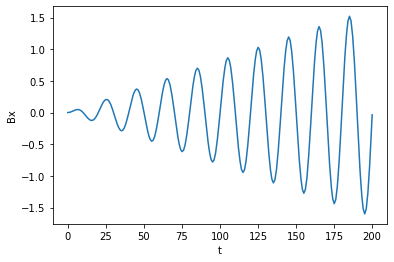

In [ ]:
plt.plot(df['t'], df['Bx'], '-')
plt.xlabel('t')
plt.ylabel('Bx')
plt.show()

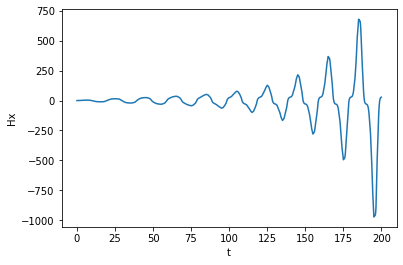

In [ ]:
plt.plot(df['t'], df['Hx'])
plt.xlabel('t')
plt.ylabel('Hx')
plt.show()

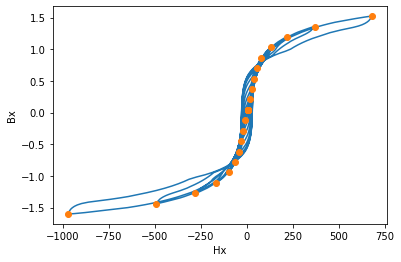

In [ ]:
v = find_ip_index(df['Bx'].to_numpy())
plt.plot(df['Hx'], df['Bx'])
plt.plot(df['Hx'][v], df['Bx'][v], 'o')
plt.xlabel('Hx')
plt.ylabel('Bx')
plt.show()

# Training and Testing Sets

## Utility: Timestep Generation

Since our data has very few inflection points (but those are very important), we use SMOTE to try to oversample around these points.

This should only be done for training data.

In [ ]:
def generate_timesteps(df, window=1, resample=True):
  assert window > 0

  # first is to find the X, Y

  y = np.zeros((len(df), window, 1))
  x = np.zeros((len(df), window, 2))

  for w in range(window):
    y[w:, window - w - 1, 0] = df['Bx'][:len(df) - w]

  for w in range(window):
    x[w:, window - w - 1, 0] = df['Hx'][:len(df) - w]

  for w in range(window):
    x[w + 1:, window - w - 1, 1] = df['Bx'][:len(df) - w - 1]

  if not resample:
    # then we're done
    return (x, y[:, -1])

  # then we find the inflection points
  # note that we one-hot encode it
  indices = find_ip_index(df['Bx'].to_numpy())
  ip = np.zeros(len(df))
  for w in range(window):
    # need a loop here because if a series contains an inflection point,
    # all subsequent
    ip[indices + w] = 1

  # then we feed it to SMOTE
  # (the ugly stuff is just reshaping the data for SMOTE)
  v = np.concatenate([x.reshape((len(df), -1)), y[:, -1, :]], axis=1)
  v, _ = SMOTE().fit_resample(v, ip)

  # then split the SMOTE'ed result back to x and y...
  return (v[:, :-1].reshape((-1, window, 2)), v[:, -1:])

## M6 (2000 data point version)

In [ ]:
(M6_train_X, M6_train_Y) = generate_timesteps(pd.read_csv('./M6_train.csv'), window=30)
(M6_test_X, M6_test_Y)   = generate_timesteps(pd.read_csv('./M6_test.csv'), window=30, resample=False)

print("Training Set")
print(f"  X: {M6_train_X.shape}")
print(f"  Y: {M6_train_Y.shape}")

print("Testing Set")
print(f"  X: {M6_test_X.shape}")
print(f"  Y: {M6_test_Y.shape}")

Training Set
  X: (2784, 30, 2)
  Y: (2784, 1)
Testing Set
  X: (11766, 30, 2)
  Y: (11766, 1)


## M6 (20000 data point version)

In [ ]:
(M6_20000_train_X, M6_20000_train_Y) = generate_timesteps(pd.read_csv('./M6_train20000.csv'), window=30)

print("Training Set")
print(f"  X: {M6_20000_train_X.shape}")
print(f"  Y: {M6_20000_train_Y.shape}")

Training Set
  X: (38146, 30, 2)
  Y: (38146, 1)


## M19

In [ ]:
(M19_train_X, M19_train_Y) = generate_timesteps(pd.read_csv('./M19_train.csv'), window=30)
(M19_test_X, M19_test_Y)   = generate_timesteps(pd.read_csv('./M19_test.csv'), window=30, resample=False)

print("Training Set")
print(f"  X: {M19_train_X.shape}")
print(f"  Y: {M19_train_Y.shape}")

print("Testing Set")
print(f"  X: {M19_test_X.shape}")
print(f"  Y: {M19_test_Y.shape}")

Training Set
  X: (2784, 30, 2)
  Y: (2784, 1)
Testing Set
  X: (1178, 30, 2)
  Y: (1178, 1)


## M27

In [ ]:
(M27_train_X, M27_train_Y) = generate_timesteps(pd.read_csv('./M27_train.csv'), window=30)
(M27_test_X, M27_test_Y)   = generate_timesteps(pd.read_csv('./M27_test.csv'), window=30, resample=False)

print("Training Set")
print(f"  X: {M27_train_X.shape}")
print(f"  Y: {M27_train_Y.shape}")

print("Testing Set")
print(f"  X: {M27_test_X.shape}")
print(f"  Y: {M27_test_Y.shape}")

Training Set
  X: (2784, 30, 2)
  Y: (2784, 1)
Testing Set
  X: (1178, 30, 2)
  Y: (1178, 1)


## 20PNF1500

In [ ]:
(_20PNF1500_train_X, _20PNF1500_train_Y) = generate_timesteps(pd.read_csv('./20PNF1500_train.csv'), window=30)
(_20PNF1500_test_X, _20PNF1500_test_Y)   = generate_timesteps(pd.read_csv('./20PNF1500_test.csv'), window=30, resample=False)

print("Training Set")
print(f"  X: {_20PNF1500_train_X.shape}")
print(f"  Y: {_20PNF1500_train_Y.shape}")

print("Testing Set")
print(f"  X: {_20PNF1500_test_X.shape}")
print(f"  Y: {_20PNF1500_test_Y.shape}")

Training Set
  X: (2784, 30, 2)
  Y: (2784, 1)
Testing Set
  X: (11766, 30, 2)
  Y: (11766, 1)


# ML Models

## Temporal Convolution Network (CNV4)

In [ ]:
def new_model_cnv4():
  input = tf.keras.layers.Input(shape=(7, 2))

  x = input
  for i in range(4):
    x = tf.keras.layers.Conv1D(128, kernel_size=(4,), padding='causal', activation='swish')(x)
    y = tf.keras.layers.Conv1D(128, kernel_size=(4,), padding='causal', activation='swish')(x)
    x = tf.keras.layers.Add()([x, y])

  x = tf.keras.layers.Conv1D(128, kernel_size=(3,), activation='swish')(x)
  x = tf.keras.layers.Dense(128, activation='swish')(x)

  x = tf.keras.layers.Conv1D(128, kernel_size=(3,), activation='swish')(x)
  x = tf.keras.layers.Dense(128, activation='swish')(x)

  x = tf.keras.layers.Conv1D(128, kernel_size=(3,), activation='swish')(x)
  x = tf.keras.layers.Dense(128, activation='swish')(x)

  x = tf.keras.layers.Dense(1, activation='linear')(x)
  x = tf.keras.layers.Flatten()(x)

  model = tf.keras.Model(inputs=input, outputs=x)
  return model

new_model_cnv4().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7, 2)]       0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 7, 128)       1152        ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 7, 128)       65664       ['conv1d[0][0]']                 
                                                                                                  
 add (Add)                      (None, 7, 128)       0           ['conv1d[0][0]',                 
                                                                  'conv1d_1[0][0]']           

## LSTM

In [ ]:
def new_model_lstm():
  return tf.keras.Sequential([
    tf.keras.layers.LSTM(400, input_shape=(None, 2), return_sequences=True),
    tf.keras.layers.LSTM(400),
    tf.keras.layers.Dense(1),
  ])

new_model_lstm().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 400)         644800    
                                                                 
 lstm_1 (LSTM)               (None, 400)               1281600   
                                                                 
 dense_4 (Dense)             (None, 1)                 401       
                                                                 
Total params: 1,926,801
Trainable params: 1,926,801
Non-trainable params: 0
_________________________________________________________________


## GRU1

In [ ]:
def new_model_gru1():
  input = tf.keras.Input(shape=(None, 2))

  x = tf.keras.layers.GRU(32, return_sequences=True)(input)
  x = tf.keras.layers.GRU(1)(x)
  x = 2 * x

  model = tf.keras.Model(input, x)
  return model

new_model_gru1().summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 2)]         0         
                                                                 
 gru (GRU)                   (None, None, 32)          3456      
                                                                 
 gru_1 (GRU)                 (None, 1)                 105       
                                                                 
 tf.math.multiply (TFOpLambd  (None, 1)                0         
 a)                                                              
                                                                 
Total params: 3,561
Trainable params: 3,561
Non-trainable params: 0
_________________________________________________________________


# Model Utilities

In [ ]:
def compile_and_fit(model, train_X, train_Y,
                    epochs=1000,
                    patience=10,
                    min_delta=0,
                    batch_size=50,
                    seed=9763):
  if seed is not None:
    np.random.seed(seed)
    tf.random.set_seed(seed)

  model.compile(loss='mse', optimizer='adam')
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    mode='auto',
                                                    verbose=0,
                                                    min_delta=min_delta,
                                                    patience=patience)
  return model.fit(train_X, train_Y,
                   epochs=epochs,
                   batch_size=batch_size,
                   callbacks=[early_stopping])

In [ ]:
def plot_train_stats(history):
  plt.plot(history.history['loss'])
  plt.title('Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.show()

In [ ]:
def plot_predictions(pred, actual, **kwargs):
  (fig, ax) = plt.subplots(2, sharex=True, **kwargs)

  ax[0].plot(actual, label='expected')
  ax[0].plot(pred, label='prediction')
  ax[0].set_ylabel('Bx')
  ax[0].legend()

  ax[1].plot(np.abs(actual - pred))
  ax[1].set_ylabel('delta')
  ax[1].grid()

  plt.xlabel('t')
  plt.show()

  print(f"MSE: {np.square(actual - pred).mean()}")

In [ ]:
def inference_loop(model, data_X):
  data_X = np.array(data_X, copy=True)

  y = np.empty(len(data_X))
  print(f"Start inference loop on {len(data_X)} samples...", end="")
  start = time()
  for i in range(len(data_X) - 1):
    y[i] = model.predict(data_X[i, None]).flatten()[-1]

    data_X[i + 1, :-1, 1] = data_X[i, 1:, 1]
    data_X[i + 1, -1, 1] = y[i]

  i = len(data_X) - 1
  y[i] = model.predict(data_X[i, None]).flatten()[-1]
  end = time()
  print(f" DONE after {end - start}s")
  return y.reshape((-1, 1))

# Model Performance

## CNV4

Note that CNV4 uses 7 timesteps while the data has 30. Need to only keep the last 7.

### M6 (2000 data point version)

Epoch 1/1000
56/56 [==============================] - 4s 44ms/step - loss: 0.0953
Epoch 2/1000
56/56 [==============================] - 3s 45ms/step - loss: 0.0144
Epoch 3/1000
56/56 [==============================] - 2s 44ms/step - loss: 0.0132
Epoch 4/1000
56/56 [==============================] - 2s 44ms/step - loss: 0.0096
Epoch 5/1000
56/56 [==============================] - 2s 44ms/step - loss: 0.0054
Epoch 6/1000
56/56 [==============================] - 3s 46ms/step - loss: 0.0027
Epoch 7/1000
56/56 [==============================] - 3s 46ms/step - loss: 0.0022
Epoch 8/1000
56/56 [==============================] - 3s 45ms/step - loss: 0.0012
Epoch 9/1000
56/56 [==============================] - 3s 45ms/step - loss: 9.3469e-04
Epoch 10/1000
56/56 [==============================] - 3s 45ms/step - loss: 8.0625e-04
Epoch 11/1000
56/56 [==============================] - 3s 45ms/step - loss: 0.0013
Epoch 12/1000
56/56 [==============================] - 3s 45ms/step - loss: 7.1380e-04
E

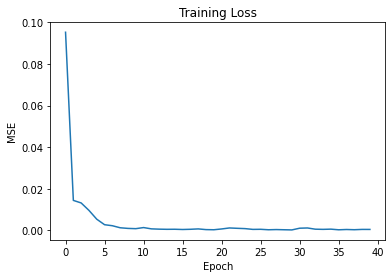

In [ ]:
model = new_model_cnv4()
history = compile_and_fit(model, M6_train_X[:, -7:, :], M6_train_Y)
model.save('./Model_CNV4_M6')
plot_train_stats(history)
del model, history

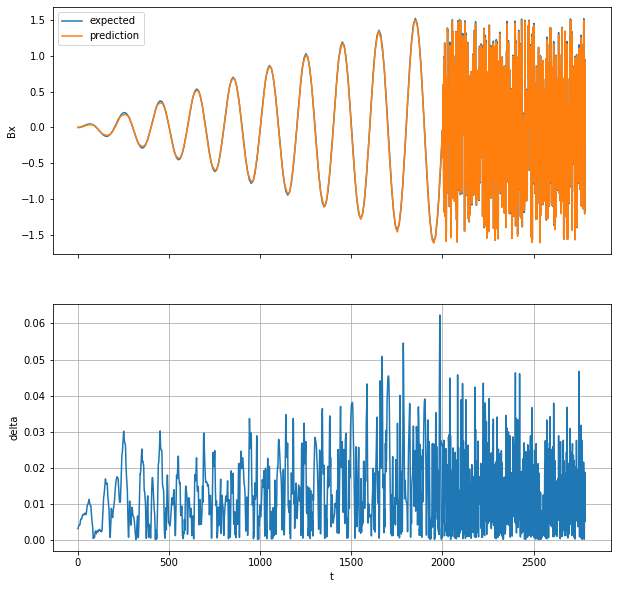

MSE: 0.00025586121437097667


In [ ]:
model = tf.keras.models.load_model('./Model_CNV4_M6')
pred = model.predict(M6_train_X[:, -7:, :])
del model

plot_predictions(pred, M6_train_Y, figsize=(10, 10))

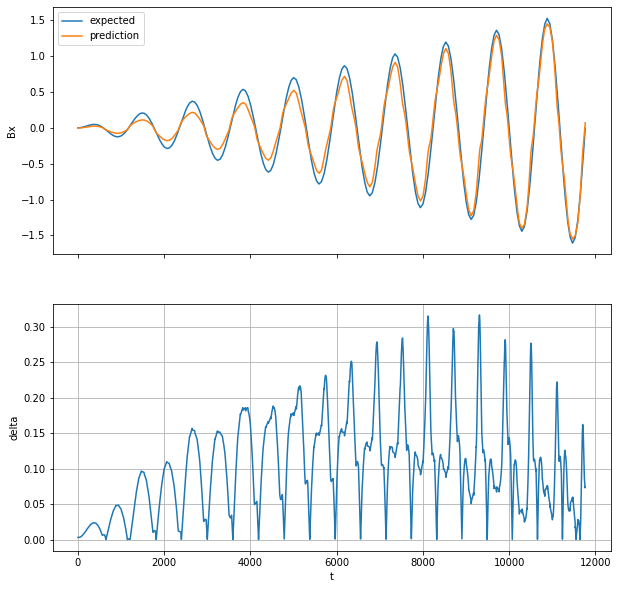

MSE: 0.01507322668047515


In [ ]:
model = tf.keras.models.load_model('./Model_CNV4_M6')
pred = model.predict(M6_test_X[:, -7:, :])
del model

plot_predictions(pred, M6_test_Y, figsize=(10, 10))

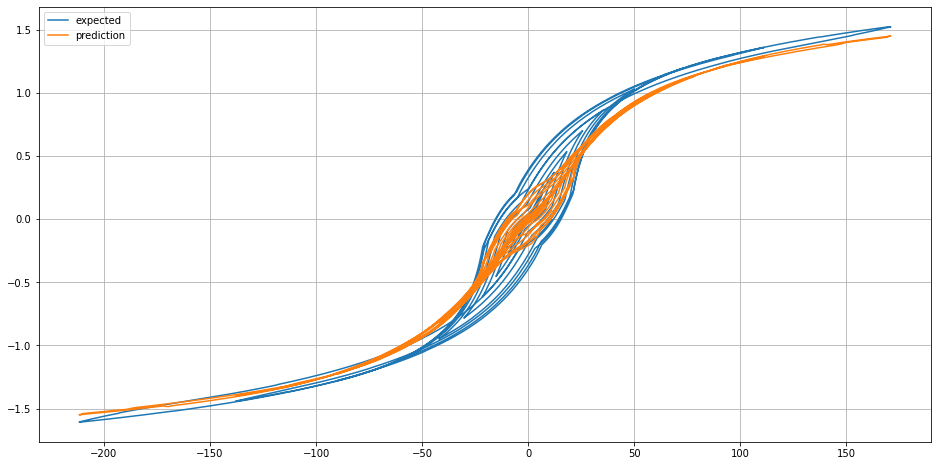

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(M6_test_X[:, -1, 0], M6_test_Y, label='expected')
plt.plot(M6_test_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

Start inference loop on 11766 samples... DONE after 546.6658508777618s


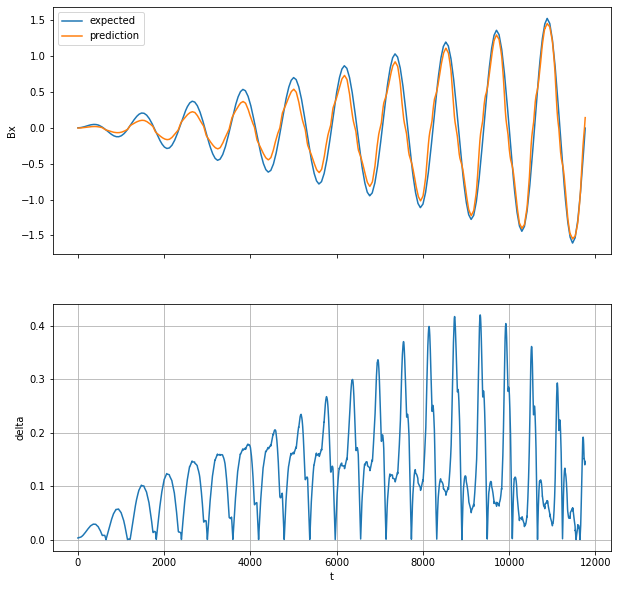

MSE: 0.022222812409452855


In [ ]:
model = tf.keras.models.load_model('./Model_CNV4_M6')
pred = inference_loop(model, M6_test_X[:, -7:, :])
del model

plot_predictions(pred, M6_test_Y, figsize=(10, 10))

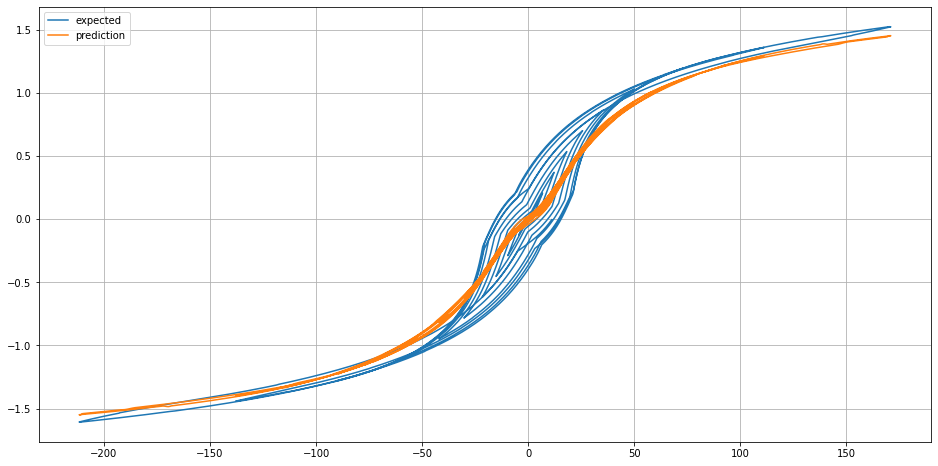

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(M6_test_X[:, -1, 0], M6_test_Y, label='expected')
plt.plot(M6_test_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

### M19

Epoch 1/1000
56/56 [==============================] - 4s 45ms/step - loss: 0.9780
Epoch 2/1000
56/56 [==============================] - 3s 45ms/step - loss: 0.0172
Epoch 3/1000
56/56 [==============================] - 3s 45ms/step - loss: 0.0135
Epoch 4/1000
56/56 [==============================] - 2s 45ms/step - loss: 0.0137
Epoch 5/1000
56/56 [==============================] - 2s 44ms/step - loss: 0.0080
Epoch 6/1000
56/56 [==============================] - 2s 44ms/step - loss: 0.0059
Epoch 7/1000
56/56 [==============================] - 3s 45ms/step - loss: 0.0064
Epoch 8/1000
56/56 [==============================] - 2s 44ms/step - loss: 0.0052
Epoch 9/1000
56/56 [==============================] - 2s 44ms/step - loss: 0.0057
Epoch 10/1000
56/56 [==============================] - 2s 44ms/step - loss: 0.0042
Epoch 11/1000
56/56 [==============================] - 2s 44ms/step - loss: 0.0054
Epoch 12/1000
56/56 [==============================] - 2s 44ms/step - loss: 0.0053
Epoch 13/1000

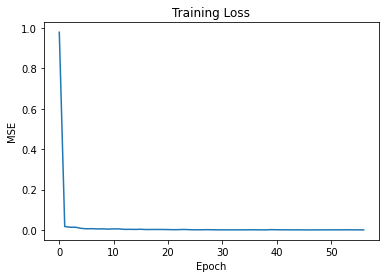

In [ ]:
model = new_model_cnv4()
history = compile_and_fit(model, M19_train_X[:, -7:, :], M19_train_Y)
model.save('./Model_CNV4_M19')
plot_train_stats(history)
del model, history

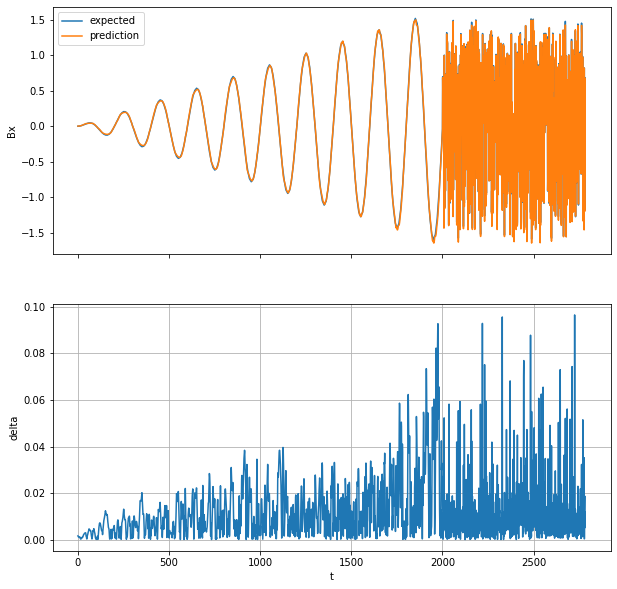

MSE: 0.00030728220578850226


In [ ]:
model = tf.keras.models.load_model('./Model_CNV4_M19')
pred = model.predict(M19_train_X[:, -7:, :])
del model

plot_predictions(pred, M19_train_Y, figsize=(10, 10))

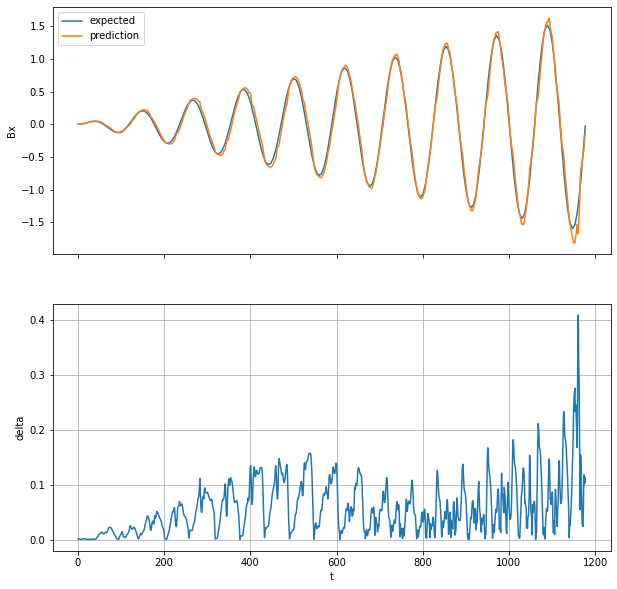

MSE: 0.005833565728646582


In [ ]:
model = tf.keras.models.load_model('./Model_CNV4_M19')
pred = model.predict(M19_test_X[:, -7:, :])
del model

plot_predictions(pred, M19_test_Y, figsize=(10, 10))

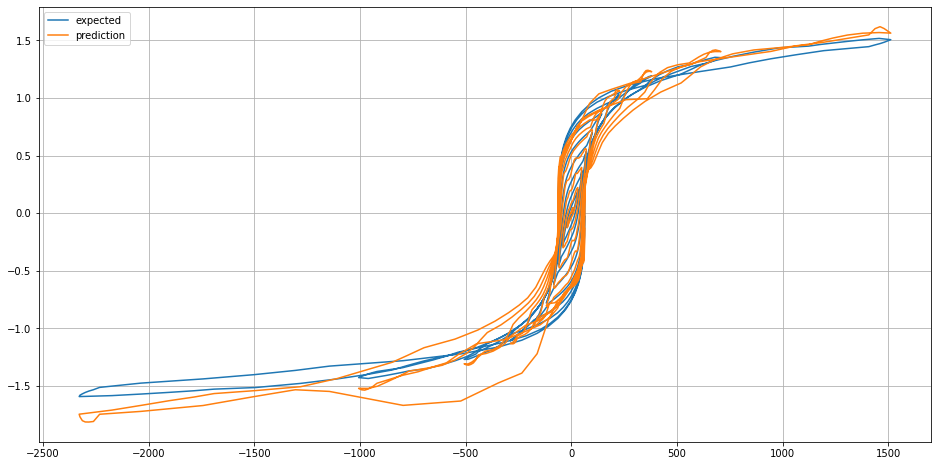

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(M19_test_X[:, -1, 0], M19_test_Y, label='expected')
plt.plot(M19_test_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

Start inference loop on 1178 samples... DONE after 54.341148376464844s


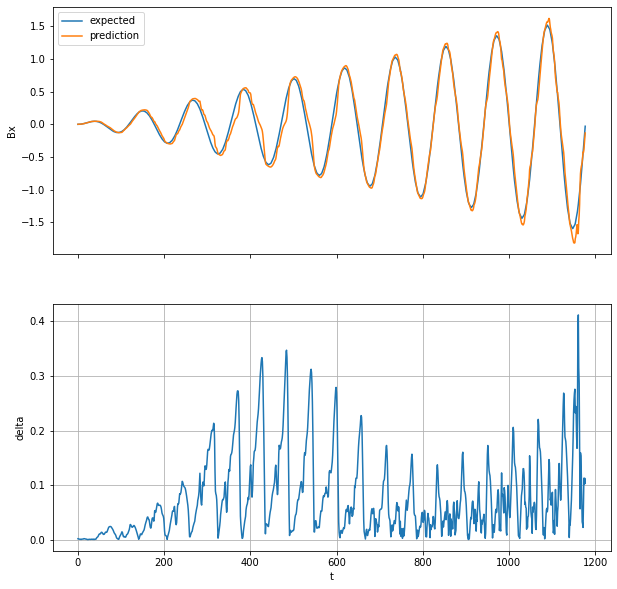

MSE: 0.0110374741092038


In [ ]:
model = tf.keras.models.load_model('./Model_CNV4_M19')
pred = inference_loop(model, M19_test_X[:, -7:, :])
del model

plot_predictions(pred, M19_test_Y, figsize=(10, 10))

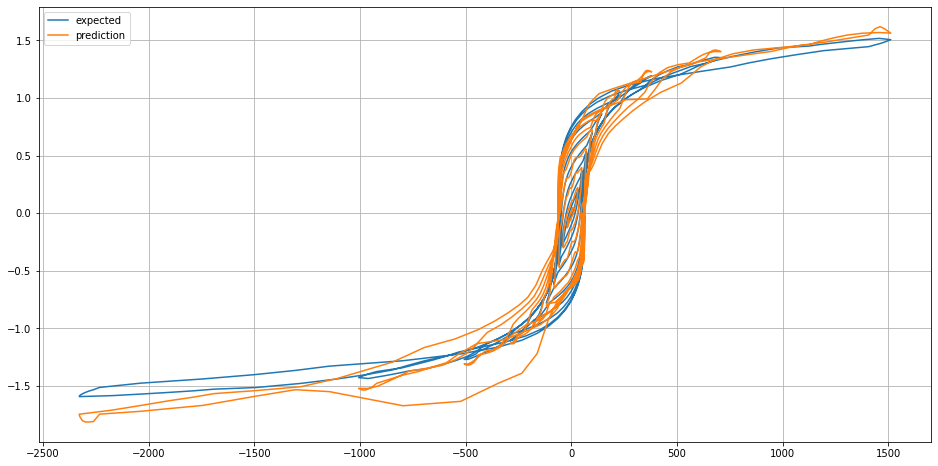

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(M19_test_X[:, -1, 0], M19_test_Y, label='expected')
plt.plot(M19_test_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

### M27

Epoch 1/1000
56/56 [==============================] - 4s 45ms/step - loss: 2.0036
Epoch 2/1000
56/56 [==============================] - 2s 44ms/step - loss: 0.0414
Epoch 3/1000
56/56 [==============================] - 2s 45ms/step - loss: 0.0315
Epoch 4/1000
56/56 [==============================] - 3s 46ms/step - loss: 0.0823
Epoch 5/1000
56/56 [==============================] - 3s 45ms/step - loss: 0.0175
Epoch 6/1000
56/56 [==============================] - 2s 44ms/step - loss: 0.0121
Epoch 7/1000
56/56 [==============================] - 3s 45ms/step - loss: 0.0091
Epoch 8/1000
56/56 [==============================] - 3s 45ms/step - loss: 0.0083
Epoch 9/1000
56/56 [==============================] - 3s 45ms/step - loss: 0.0068
Epoch 10/1000
56/56 [==============================] - 3s 45ms/step - loss: 0.0071
Epoch 11/1000
56/56 [==============================] - 3s 45ms/step - loss: 0.0062
Epoch 12/1000
56/56 [==============================] - 2s 45ms/step - loss: 0.0051
Epoch 13/1000

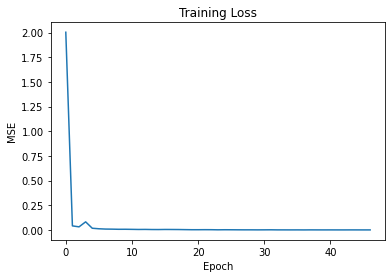

In [ ]:
model = new_model_cnv4()
history = compile_and_fit(model, M27_train_X[:, -7:, :], M27_train_Y)
model.save('./Model_CNV4_M27')
plot_train_stats(history)
del model, history

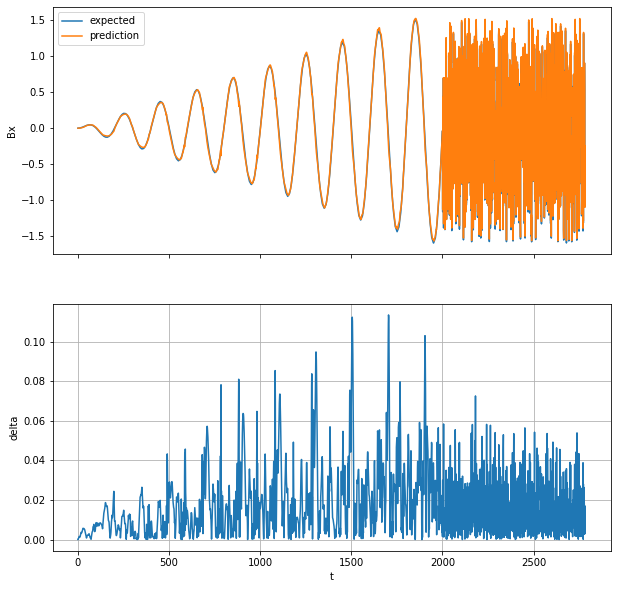

MSE: 0.0006170438027130169


In [ ]:
model = tf.keras.models.load_model('./Model_CNV4_M27')
pred = model.predict(M27_train_X[:, -7:, :])
del model

plot_predictions(pred, M27_train_Y, figsize=(10, 10))

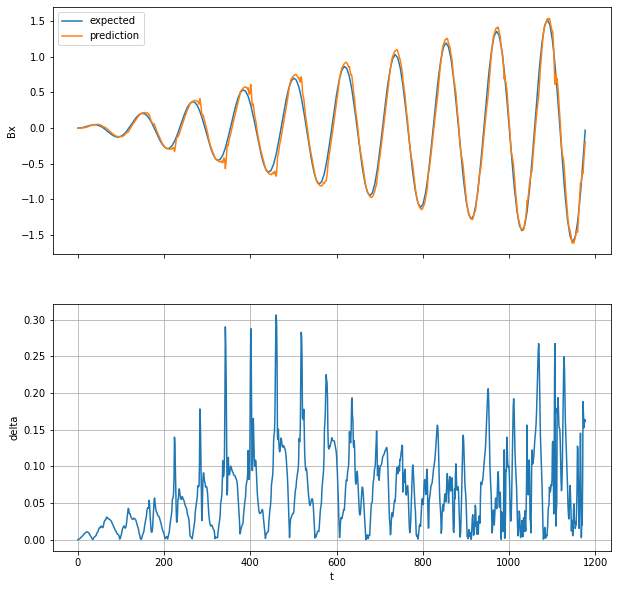

MSE: 0.007196441280633578


In [ ]:
model = tf.keras.models.load_model('./Model_CNV4_M27')
pred = model.predict(M27_test_X[:, -7:, :])
del model

plot_predictions(pred, M27_test_Y, figsize=(10, 10))

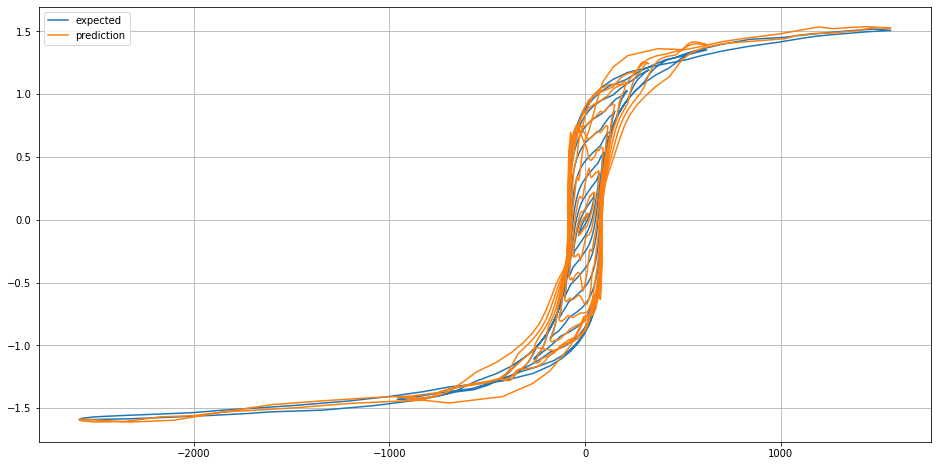

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(M27_test_X[:, -1, 0], M27_test_Y, label='expected')
plt.plot(M27_test_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

Start inference loop on 1178 samples... DONE after 54.15776586532593s


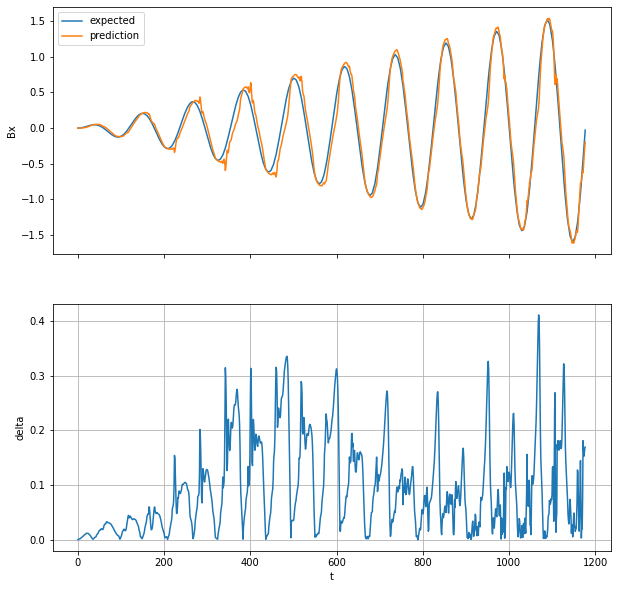

MSE: 0.015576676246356584


In [ ]:
model = tf.keras.models.load_model('./Model_CNV4_M27')
pred = inference_loop(model, M27_test_X[:, -7:, :])
del model

plot_predictions(pred, M27_test_Y, figsize=(10, 10))

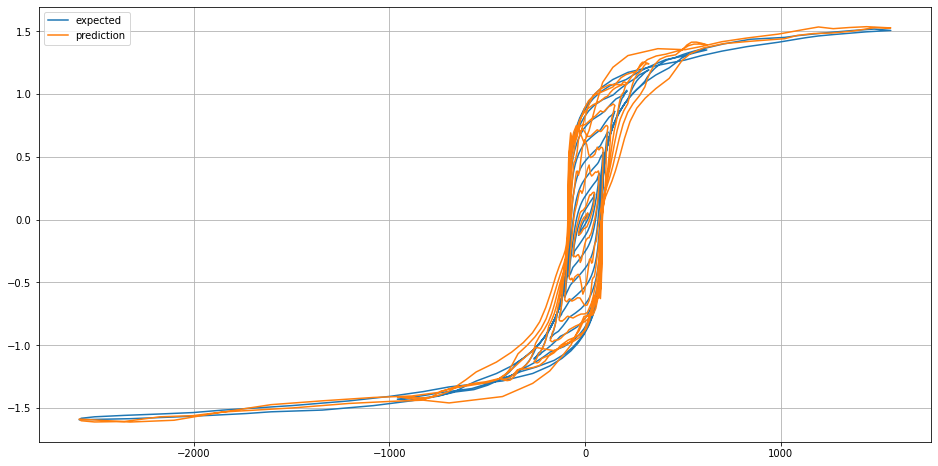

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(M27_test_X[:, -1, 0], M27_test_Y, label='expected')
plt.plot(M27_test_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

### 20PNF1500

Epoch 1/1000
56/56 [==============================] - 4s 45ms/step - loss: 0.5661
Epoch 2/1000
56/56 [==============================] - 2s 44ms/step - loss: 0.0123
Epoch 3/1000
56/56 [==============================] - 2s 44ms/step - loss: 0.0085
Epoch 4/1000
56/56 [==============================] - 2s 44ms/step - loss: 0.0061
Epoch 5/1000
56/56 [==============================] - 2s 44ms/step - loss: 0.0066
Epoch 6/1000
56/56 [==============================] - 2s 44ms/step - loss: 0.0038
Epoch 7/1000
56/56 [==============================] - 2s 44ms/step - loss: 0.0034
Epoch 8/1000
56/56 [==============================] - 2s 44ms/step - loss: 0.0028
Epoch 9/1000
56/56 [==============================] - 2s 44ms/step - loss: 0.0024
Epoch 10/1000
56/56 [==============================] - 2s 44ms/step - loss: 0.0018
Epoch 11/1000
56/56 [==============================] - 2s 45ms/step - loss: 0.0018
Epoch 12/1000
56/56 [==============================] - 2s 44ms/step - loss: 0.0018
Epoch 13/1000

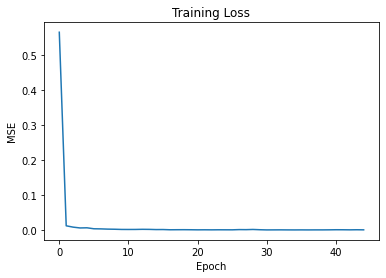

In [ ]:
model = new_model_cnv4()
history = compile_and_fit(model, _20PNF1500_train_X[:, -7:, :], _20PNF1500_train_Y)
model.save('./Model_CNV4__20PNF1500')
plot_train_stats(history)
del model, history

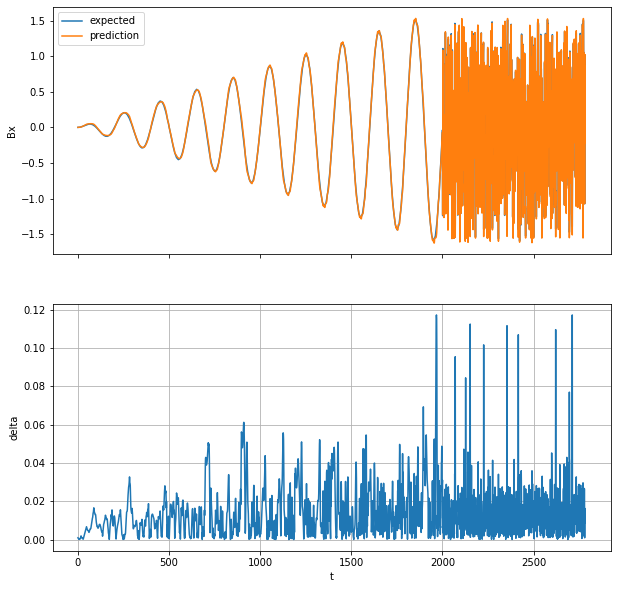

MSE: 0.0003854514278559216


In [ ]:
model = tf.keras.models.load_model('./Model_CNV4__20PNF1500')
pred = model.predict(_20PNF1500_train_X[:, -7:, :])
del model

plot_predictions(pred, _20PNF1500_train_Y, figsize=(10, 10))

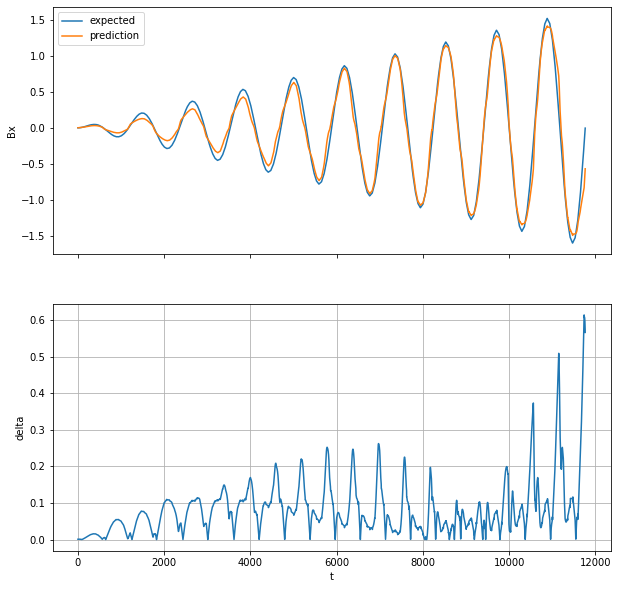

MSE: 0.012347369234127766


In [ ]:
model = tf.keras.models.load_model('./Model_CNV4__20PNF1500')
pred = model.predict(_20PNF1500_test_X[:, -7:, :])
del model

plot_predictions(pred, _20PNF1500_test_Y, figsize=(10, 10))

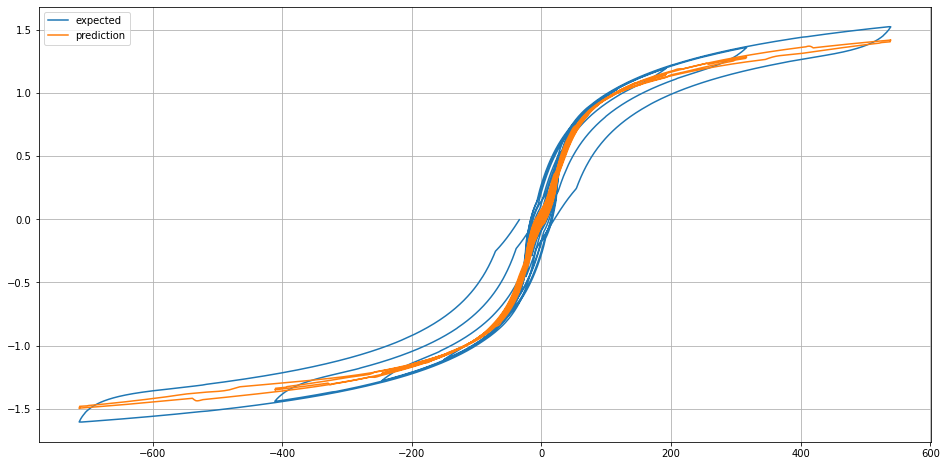

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(_20PNF1500_test_X[:, -1, 0], _20PNF1500_test_Y, label='expected')
plt.plot(_20PNF1500_test_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

Start inference loop on 11766 samples... DONE after 551.3760914802551s


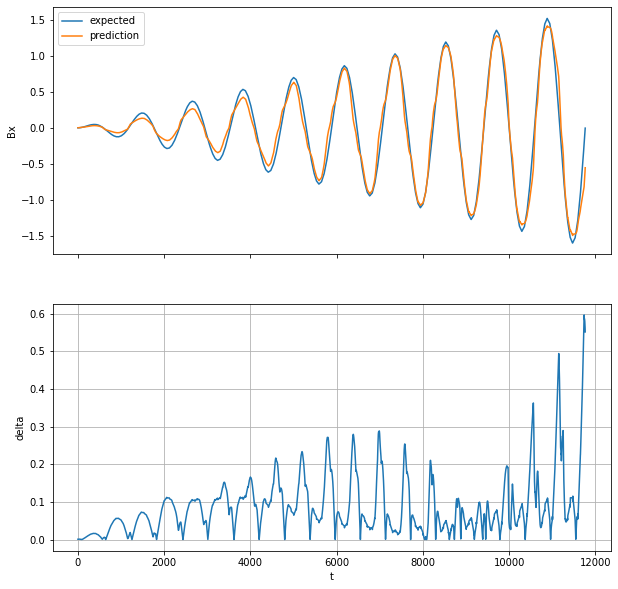

MSE: 0.013492832566978698


In [ ]:
model = tf.keras.models.load_model('./Model_CNV4__20PNF1500')
pred = inference_loop(model, _20PNF1500_test_X[:, -7:, :])
del model

plot_predictions(pred, _20PNF1500_test_Y, figsize=(10, 10))

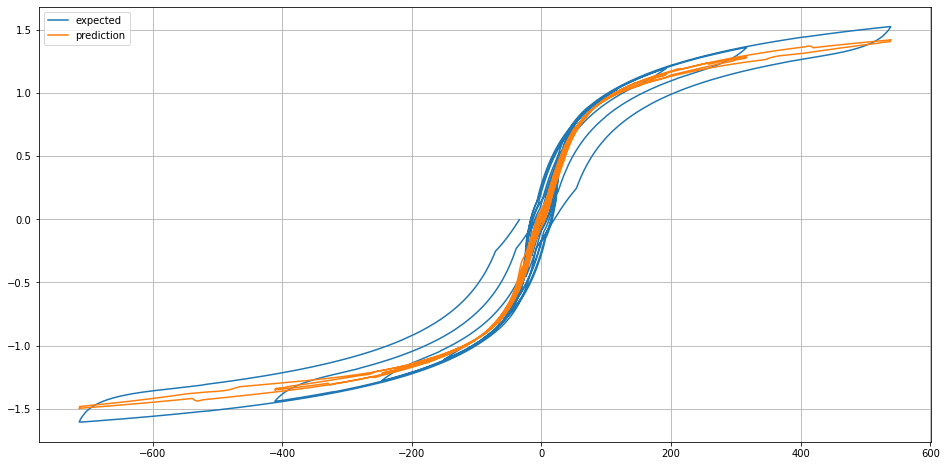

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(_20PNF1500_test_X[:, -1, 0], _20PNF1500_test_Y, label='expected')
plt.plot(_20PNF1500_test_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

## LSTM

### M6 (2000 data point version)

Epoch 1/1000
56/56 [==============================] - 36s 591ms/step - loss: 0.3989
Epoch 2/1000
56/56 [==============================] - 33s 591ms/step - loss: 0.0057
Epoch 3/1000
56/56 [==============================] - 33s 582ms/step - loss: 0.0013
Epoch 4/1000
56/56 [==============================] - 33s 591ms/step - loss: 6.1221e-04
Epoch 5/1000
56/56 [==============================] - 33s 584ms/step - loss: 4.8797e-04
Epoch 6/1000
56/56 [==============================] - 32s 578ms/step - loss: 4.3219e-04
Epoch 7/1000
56/56 [==============================] - 33s 583ms/step - loss: 3.5583e-04
Epoch 8/1000
56/56 [==============================] - 33s 581ms/step - loss: 2.9084e-04
Epoch 9/1000
56/56 [==============================] - 33s 587ms/step - loss: 2.5846e-04
Epoch 10/1000
56/56 [==============================] - 33s 593ms/step - loss: 2.4040e-04
Epoch 11/1000
56/56 [==============================] - 33s 585ms/step - loss: 2.2801e-04
Epoch 12/1000
56/56 [=====================

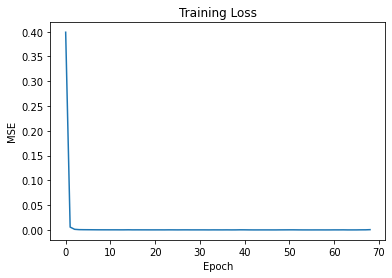

In [ ]:
model = new_model_lstm()
history = compile_and_fit(model, M6_train_X, M6_train_Y)
model.save('./Model_LSTM_M6')
plot_train_stats(history)
del model, history

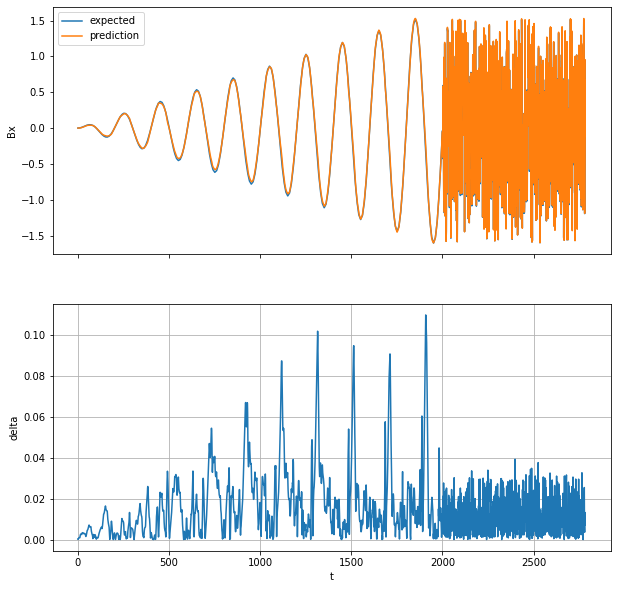

MSE: 0.0005007612929118693


In [ ]:
model = tf.keras.models.load_model('./Model_LSTM_M6')
pred = model.predict(M6_train_X)
del model

plot_predictions(pred, M6_train_Y, figsize=(10, 10))

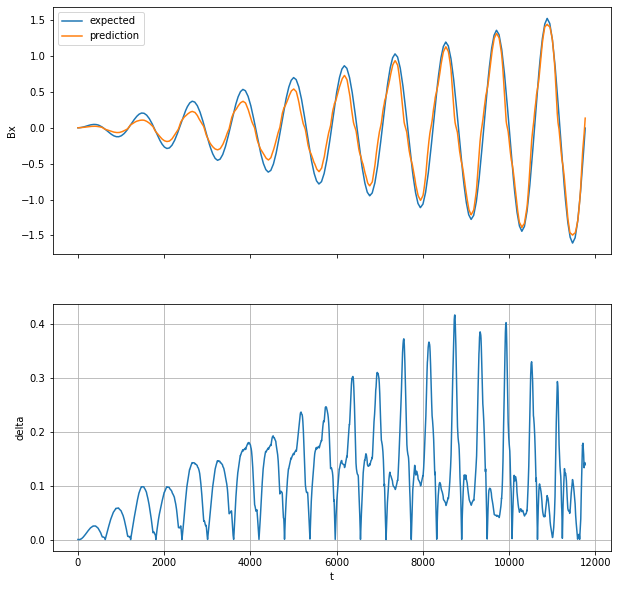

MSE: 0.019952261041605693


In [ ]:
model = tf.keras.models.load_model('./Model_LSTM_M6')
pred = model.predict(M6_test_X)
del model

plot_predictions(pred, M6_test_Y, figsize=(10, 10))

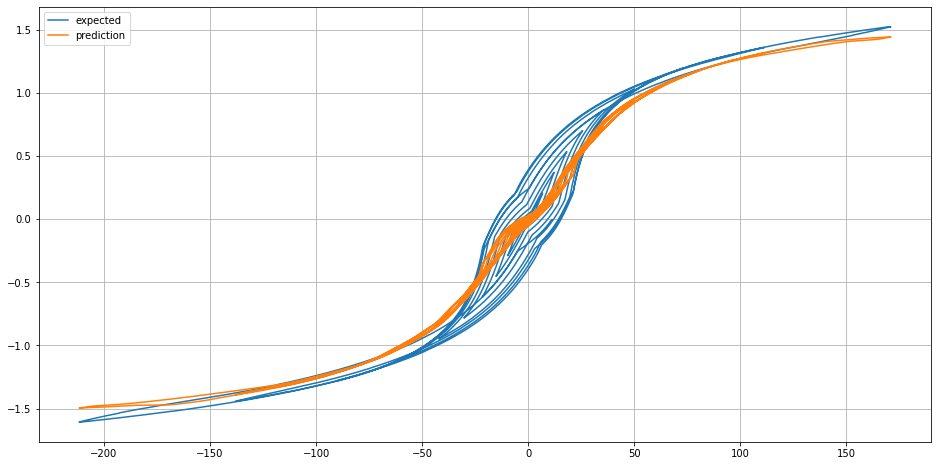

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(M6_test_X[:, -1, 0], M6_test_Y, label='expected')
plt.plot(M6_test_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

Start inference loop on 11766 samples... DONE after 724.657735824585s


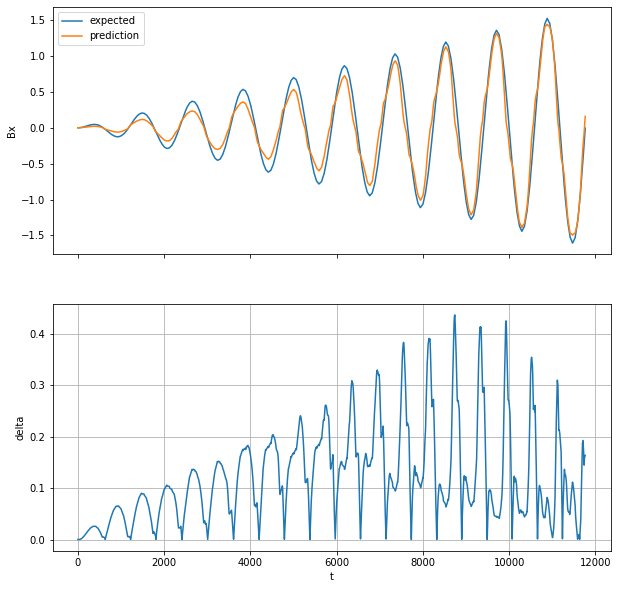

MSE: 0.022948408982157224


In [ ]:
model = tf.keras.models.load_model('./Model_LSTM_M6')
pred = inference_loop(model, M6_test_X)
del model

plot_predictions(pred, M6_test_Y, figsize=(10, 10))

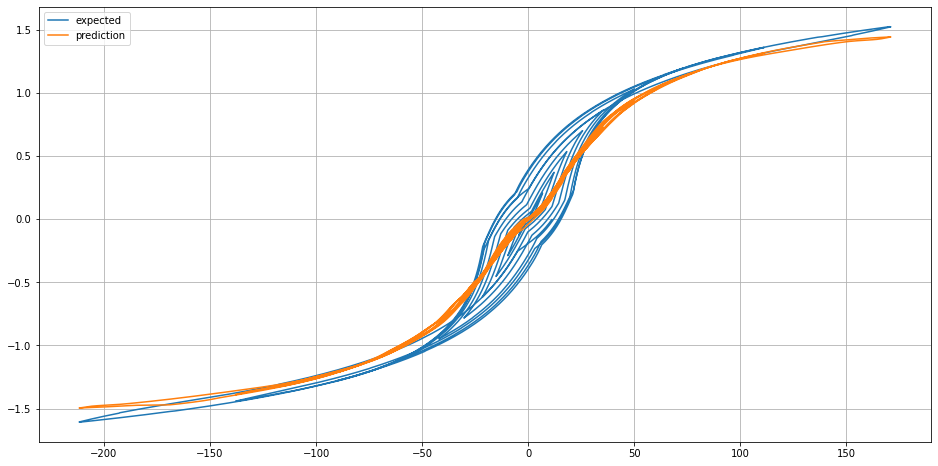

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(M6_test_X[:, -1, 0], M6_test_Y, label='expected')
plt.plot(M6_test_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

### M19

Epoch 1/1000
56/56 [==============================] - 36s 564ms/step - loss: 0.3402
Epoch 2/1000
56/56 [==============================] - 31s 560ms/step - loss: 0.0052
Epoch 3/1000
56/56 [==============================] - 31s 560ms/step - loss: 0.0018
Epoch 4/1000
56/56 [==============================] - 31s 560ms/step - loss: 0.0011
Epoch 5/1000
56/56 [==============================] - 31s 562ms/step - loss: 6.2875e-04
Epoch 6/1000
56/56 [==============================] - 32s 579ms/step - loss: 4.9667e-04
Epoch 7/1000
56/56 [==============================] - 32s 577ms/step - loss: 4.7969e-04
Epoch 8/1000
56/56 [==============================] - 32s 574ms/step - loss: 4.1161e-04
Epoch 9/1000
56/56 [==============================] - 32s 570ms/step - loss: 3.1874e-04
Epoch 10/1000
56/56 [==============================] - 32s 565ms/step - loss: 3.2616e-04
Epoch 11/1000
56/56 [==============================] - 32s 564ms/step - loss: 2.9788e-04
Epoch 12/1000
56/56 [=========================

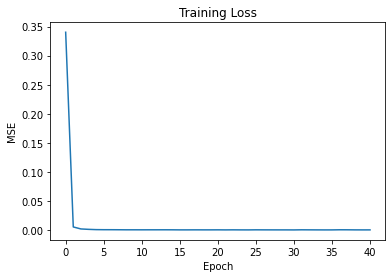

In [ ]:
model = new_model_lstm()
history = compile_and_fit(model, M19_train_X, M19_train_Y)
model.save('./Model_LSTM_M19')
plot_train_stats(history)
del model, history

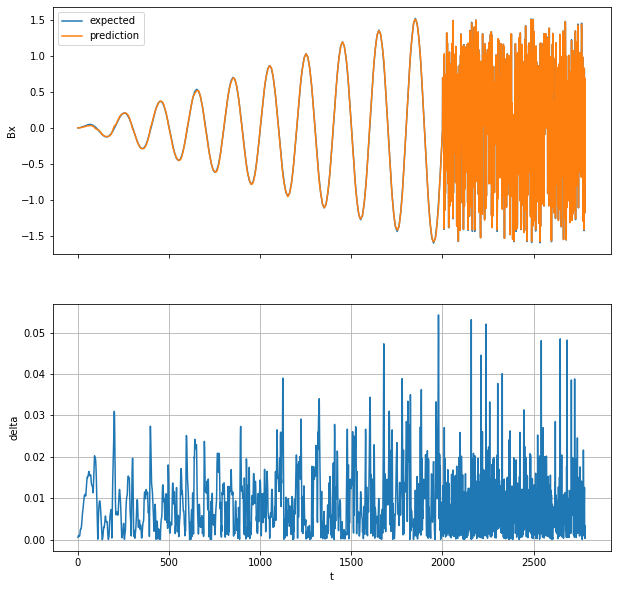

MSE: 0.00013307007293466801


In [ ]:
model = tf.keras.models.load_model('./Model_LSTM_M19')
pred = model.predict(M19_train_X)
del model

plot_predictions(pred, M19_train_Y, figsize=(10, 10))

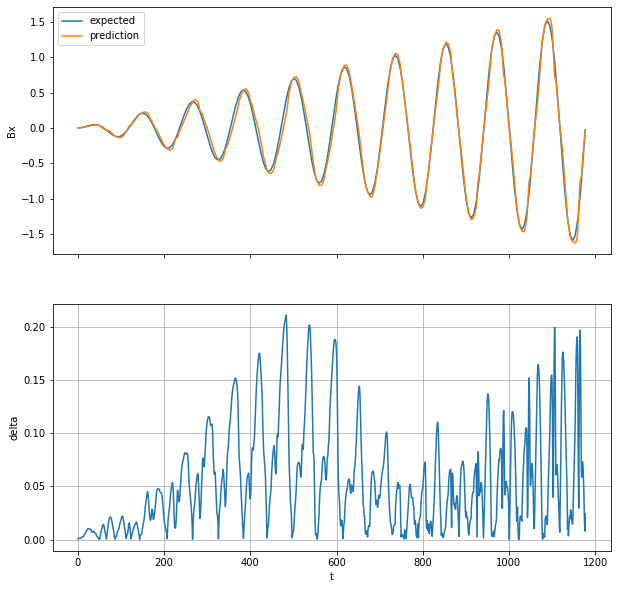

MSE: 0.005500375874902827


In [ ]:
model = tf.keras.models.load_model('./Model_LSTM_M19')
pred = model.predict(M19_test_X)
del model

plot_predictions(pred, M19_test_Y, figsize=(10, 10))

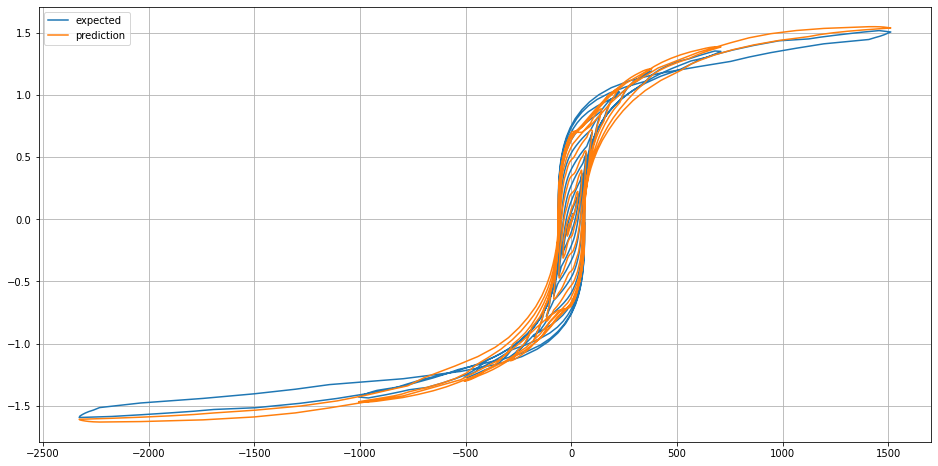

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(M19_test_X[:, -1, 0], M19_test_Y, label='expected')
plt.plot(M19_test_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

Start inference loop on 1178 samples... DONE after 71.41222262382507s


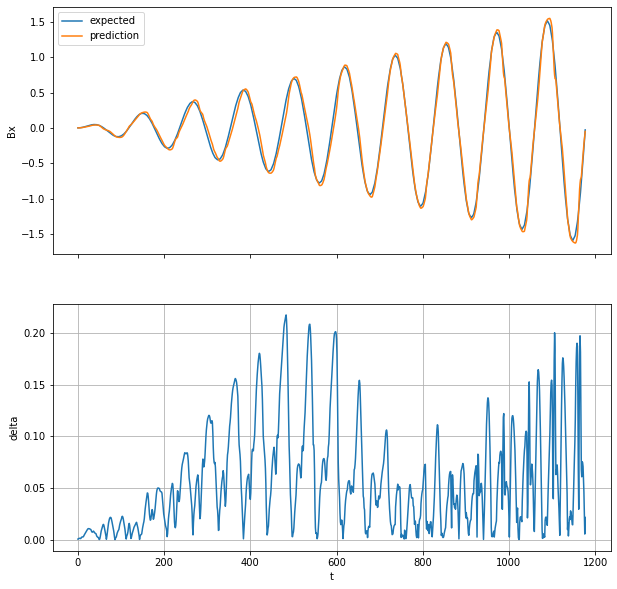

MSE: 0.005847998112100668


In [ ]:
model = tf.keras.models.load_model('./Model_LSTM_M19')
pred = inference_loop(model, M19_test_X)
del model

plot_predictions(pred, M19_test_Y, figsize=(10, 10))

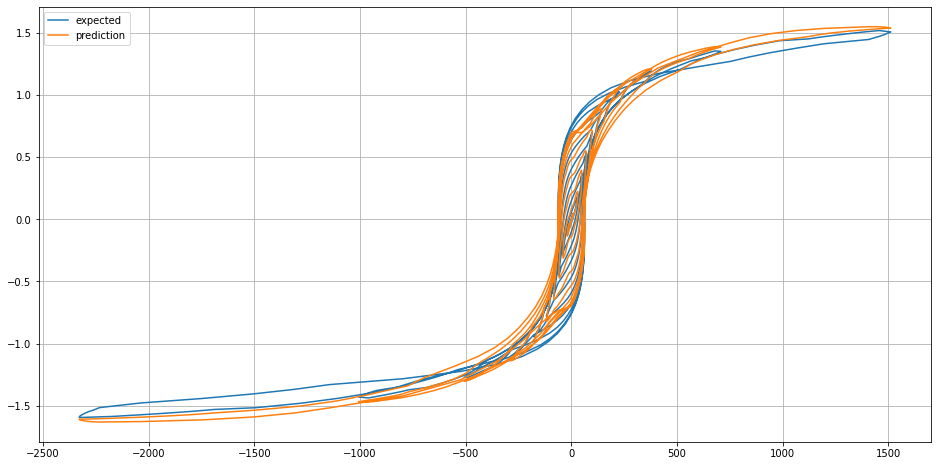

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(M19_test_X[:, -1, 0], M19_test_Y, label='expected')
plt.plot(M19_test_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

### M27

Epoch 1/1000
56/56 [==============================] - 35s 566ms/step - loss: 0.2955
Epoch 2/1000
56/56 [==============================] - 32s 563ms/step - loss: 0.0031
Epoch 3/1000
56/56 [==============================] - 31s 558ms/step - loss: 0.0015
Epoch 4/1000
56/56 [==============================] - 31s 561ms/step - loss: 9.8699e-04
Epoch 5/1000
56/56 [==============================] - 32s 562ms/step - loss: 8.1160e-04
Epoch 6/1000
56/56 [==============================] - 31s 561ms/step - loss: 7.7474e-04
Epoch 7/1000
56/56 [==============================] - 32s 563ms/step - loss: 6.3794e-04
Epoch 8/1000
56/56 [==============================] - 32s 563ms/step - loss: 5.5868e-04
Epoch 9/1000
56/56 [==============================] - 32s 572ms/step - loss: 5.1545e-04
Epoch 10/1000
56/56 [==============================] - 32s 566ms/step - loss: 4.3613e-04
Epoch 11/1000
56/56 [==============================] - 32s 568ms/step - loss: 4.5069e-04
Epoch 12/1000
56/56 [=====================

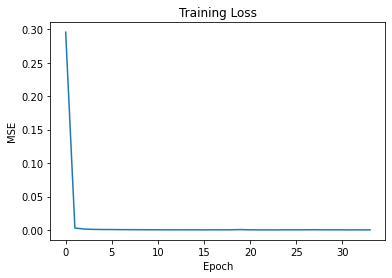

In [ ]:
model = new_model_lstm()
history = compile_and_fit(model, M27_train_X, M27_train_Y)
model.save('./Model_LSTM_M27')
plot_train_stats(history)
del model, history

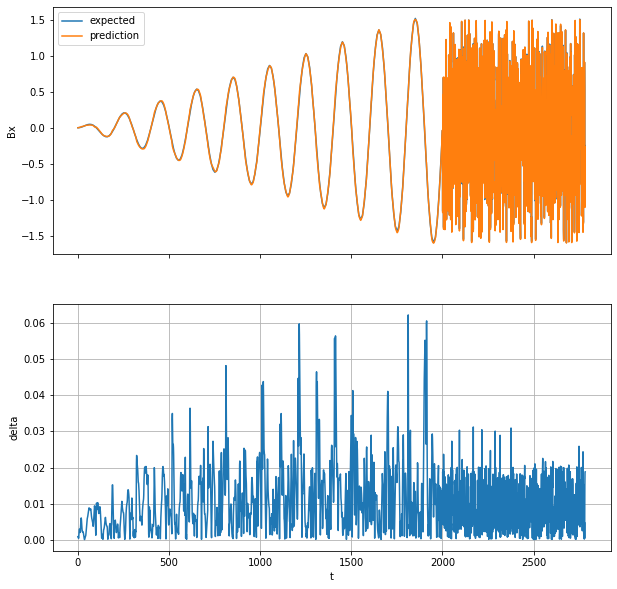

MSE: 0.00019533204675533828


In [ ]:
model = tf.keras.models.load_model('./Model_LSTM_M27')
pred = model.predict(M27_train_X)
del model

plot_predictions(pred, M27_train_Y, figsize=(10, 10))

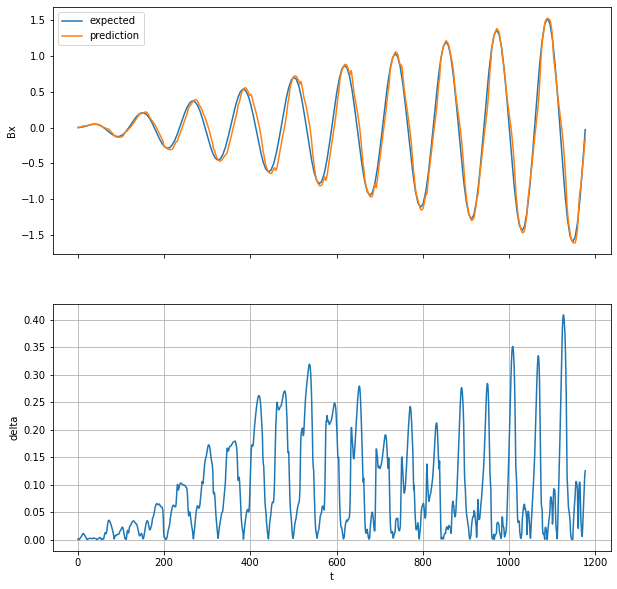

MSE: 0.016284821561873084


In [ ]:
model = tf.keras.models.load_model('./Model_LSTM_M27')
pred = model.predict(M27_test_X)
del model

plot_predictions(pred, M27_test_Y, figsize=(10, 10))

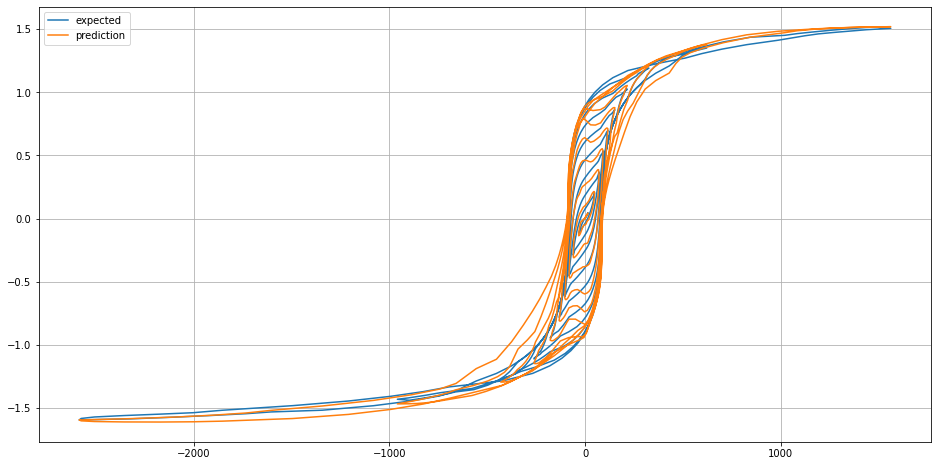

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(M27_test_X[:, -1, 0], M27_test_Y, label='expected')
plt.plot(M27_test_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

Start inference loop on 1178 samples... DONE after 70.35420107841492s


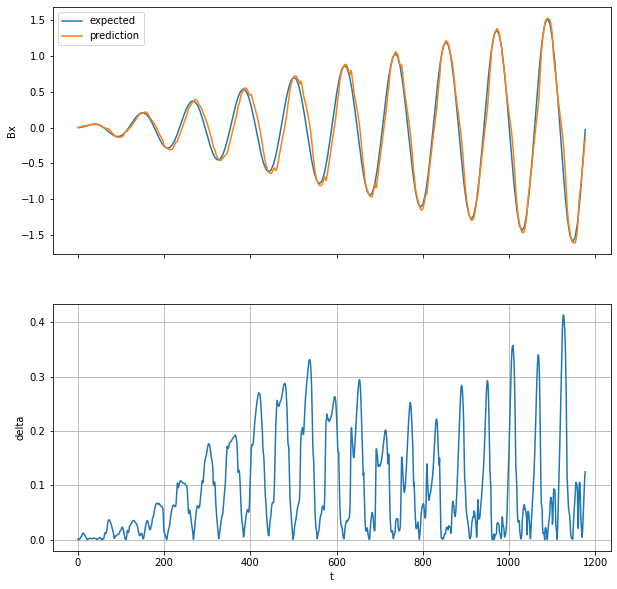

MSE: 0.017480008111463125


In [ ]:
model = tf.keras.models.load_model('./Model_LSTM_M27')
pred = inference_loop(model, M27_test_X)
del model

plot_predictions(pred, M27_test_Y, figsize=(10, 10))

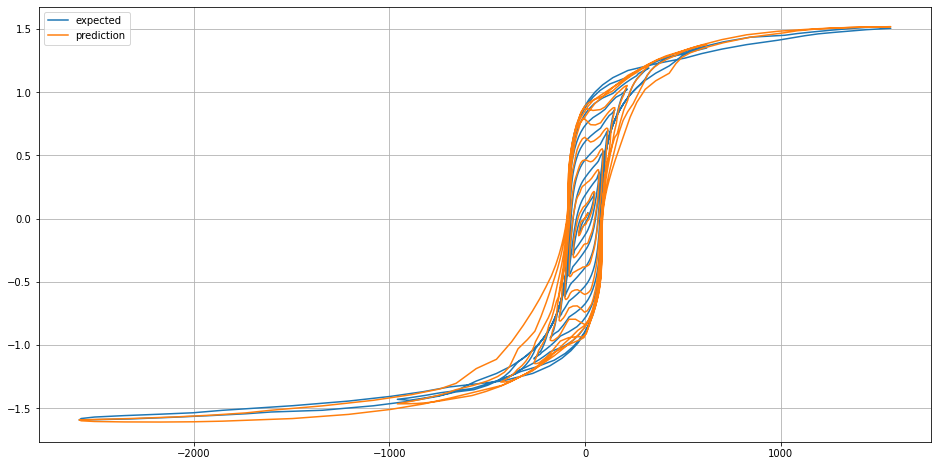

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(M27_test_X[:, -1, 0], M27_test_Y, label='expected')
plt.plot(M27_test_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

### 20PNF1500

Epoch 1/1000
56/56 [==============================] - 35s 566ms/step - loss: 0.4010
Epoch 2/1000
56/56 [==============================] - 31s 556ms/step - loss: 0.0050
Epoch 3/1000
56/56 [==============================] - 31s 559ms/step - loss: 0.0017
Epoch 4/1000
56/56 [==============================] - 31s 561ms/step - loss: 9.4344e-04
Epoch 5/1000
56/56 [==============================] - 31s 561ms/step - loss: 6.5762e-04
Epoch 6/1000
56/56 [==============================] - 31s 559ms/step - loss: 4.9562e-04
Epoch 7/1000
56/56 [==============================] - 31s 558ms/step - loss: 3.7476e-04
Epoch 8/1000
56/56 [==============================] - 32s 563ms/step - loss: 3.1480e-04
Epoch 9/1000
56/56 [==============================] - 32s 565ms/step - loss: 3.7628e-04
Epoch 10/1000
56/56 [==============================] - 32s 566ms/step - loss: 3.1482e-04
Epoch 11/1000
56/56 [==============================] - 31s 562ms/step - loss: 3.1669e-04
Epoch 12/1000
56/56 [=====================

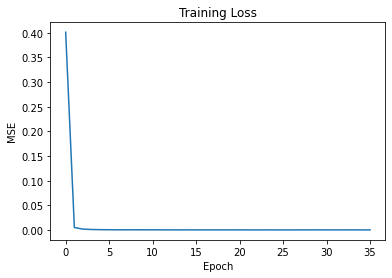

In [ ]:
model = new_model_lstm()
history = compile_and_fit(model, _20PNF1500_train_X, _20PNF1500_train_Y)
model.save('./Model_LSTM__20PNF1500')
plot_train_stats(history)
del model, history

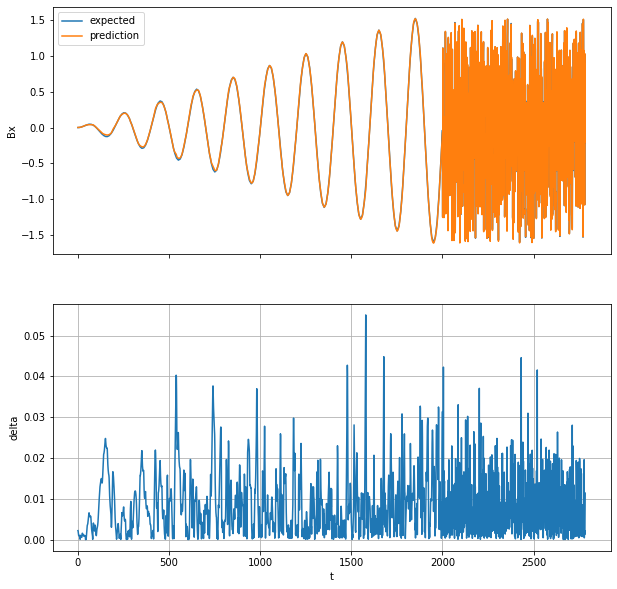

MSE: 0.0001289057417124373


In [ ]:
model = tf.keras.models.load_model('./Model_LSTM__20PNF1500')
pred = model.predict(_20PNF1500_train_X)
del model

plot_predictions(pred, _20PNF1500_train_Y, figsize=(10, 10))

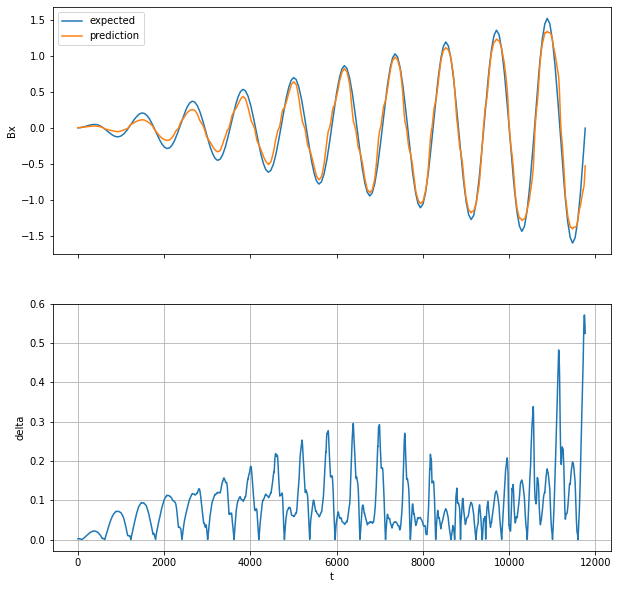

MSE: 0.013855265844621689


In [ ]:
model = tf.keras.models.load_model('./Model_LSTM__20PNF1500')
pred = model.predict(_20PNF1500_test_X)
del model

plot_predictions(pred, _20PNF1500_test_Y, figsize=(10, 10))

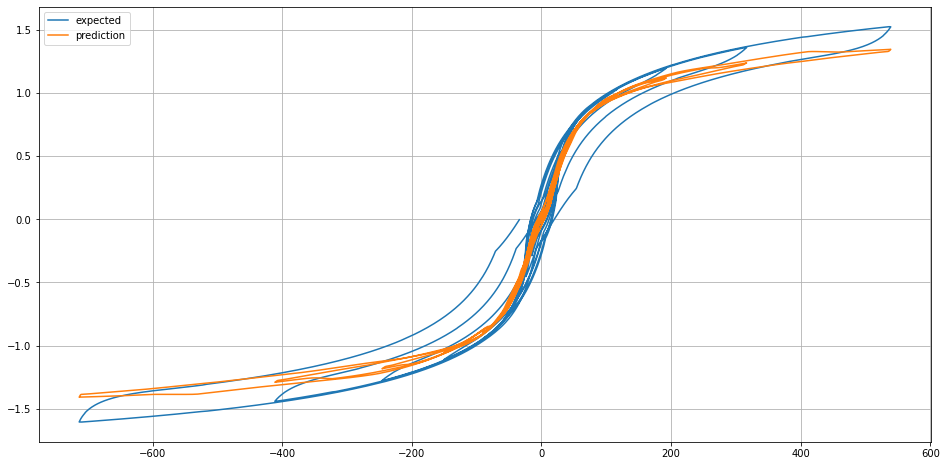

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(_20PNF1500_test_X[:, -1, 0], _20PNF1500_test_Y, label='expected')
plt.plot(_20PNF1500_test_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

Start inference loop on 11766 samples... DONE after 702.9880614280701s


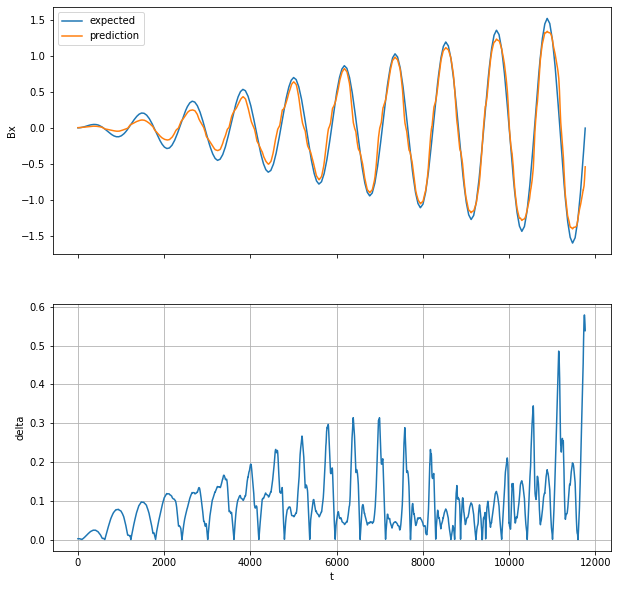

MSE: 0.015157225438262678


In [ ]:
model = tf.keras.models.load_model('./Model_LSTM__20PNF1500')
pred = inference_loop(model, _20PNF1500_test_X)
del model

plot_predictions(pred, _20PNF1500_test_Y, figsize=(10, 10))

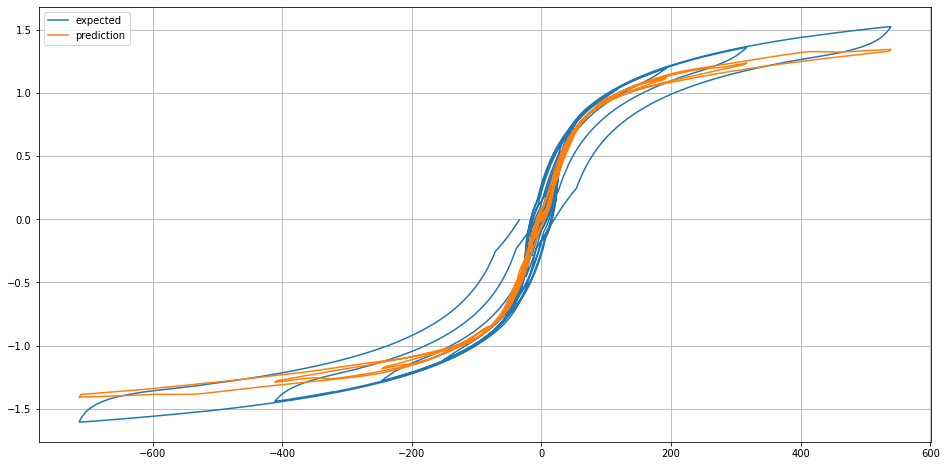

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(_20PNF1500_test_X[:, -1, 0], _20PNF1500_test_Y, label='expected')
plt.plot(_20PNF1500_test_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

## GRU1

### M6 (2000 data point version)

Epoch 1/1000
56/56 [==============================] - 9s 28ms/step - loss: 0.9903
Epoch 2/1000
56/56 [==============================] - 2s 28ms/step - loss: 0.0249
Epoch 3/1000
56/56 [==============================] - 2s 28ms/step - loss: 0.0084
Epoch 4/1000
56/56 [==============================] - 2s 28ms/step - loss: 0.0050
Epoch 5/1000
56/56 [==============================] - 2s 28ms/step - loss: 0.0036
Epoch 6/1000
56/56 [==============================] - 2s 35ms/step - loss: 0.0028
Epoch 7/1000
56/56 [==============================] - 2s 42ms/step - loss: 0.0022
Epoch 8/1000
56/56 [==============================] - 2s 28ms/step - loss: 0.0018
Epoch 9/1000
56/56 [==============================] - 2s 27ms/step - loss: 0.0015
Epoch 10/1000
56/56 [==============================] - 2s 28ms/step - loss: 0.0013
Epoch 11/1000
56/56 [==============================] - 2s 28ms/step - loss: 0.0012
Epoch 12/1000
56/56 [==============================] - 2s 28ms/step - loss: 0.0011
Epoch 13/1000

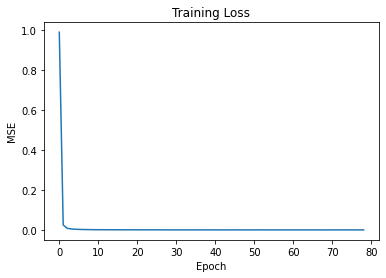

In [ ]:
model = new_model_gru1()
history = compile_and_fit(model, M6_train_X, M6_train_Y)
model.save('./Model_GRU1_M6')
plot_train_stats(history)
del model, history

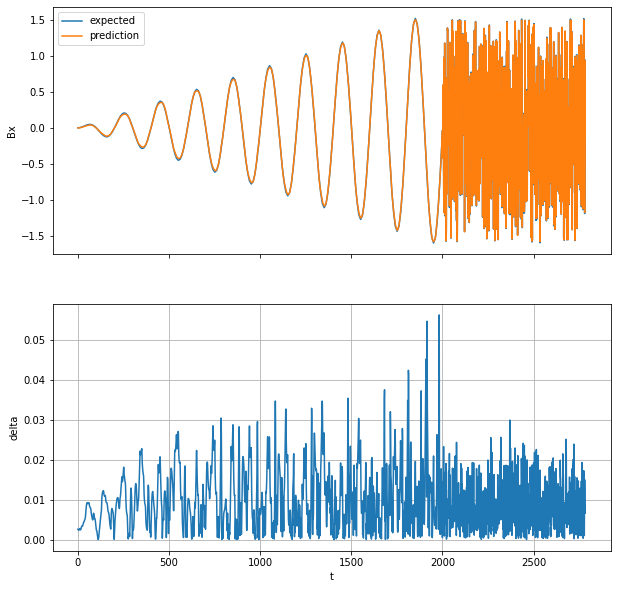

MSE: 0.00014794716957021052


In [ ]:
model = tf.keras.models.load_model('./Model_GRU1_M6')
pred = model.predict(M6_train_X)
del model

plot_predictions(pred, M6_train_Y, figsize=(10, 10))

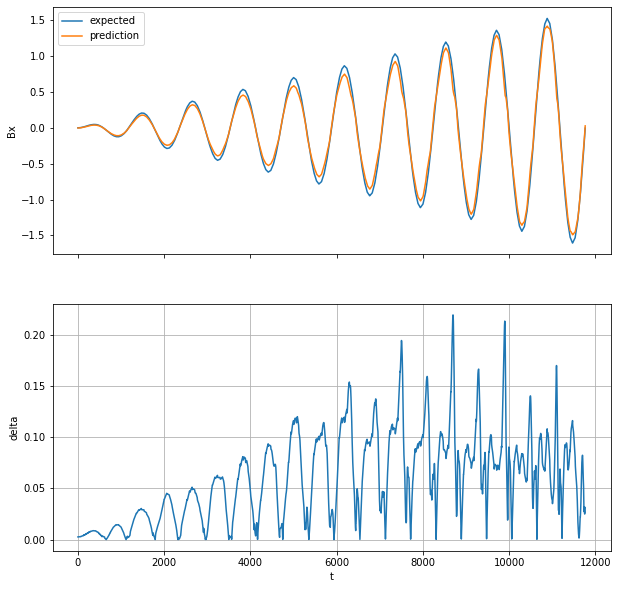

MSE: 0.0052811041693199175


In [ ]:
model = tf.keras.models.load_model('./Model_GRU1_M6')
pred = model.predict(M6_test_X)
del model

plot_predictions(pred, M6_test_Y, figsize=(10, 10))

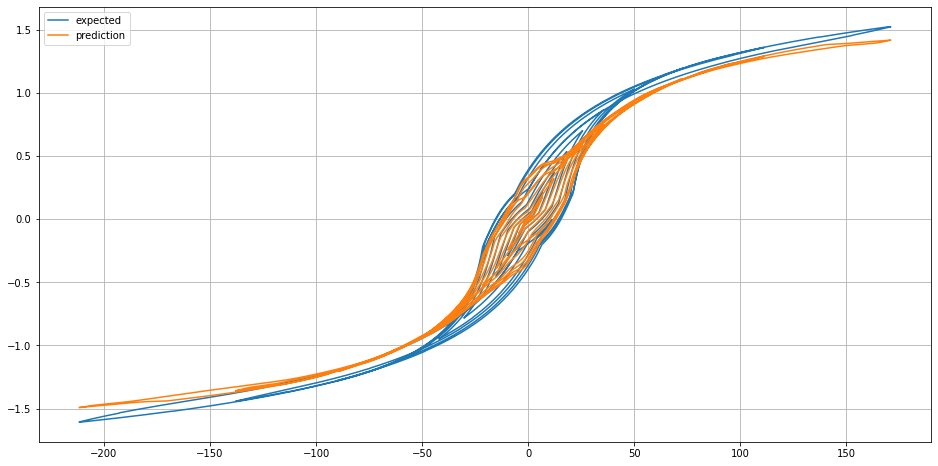

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(M6_test_X[:, -1, 0], M6_test_Y, label='expected')
plt.plot(M6_test_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

Start inference loop on 11766 samples... DONE after 565.1886937618256s


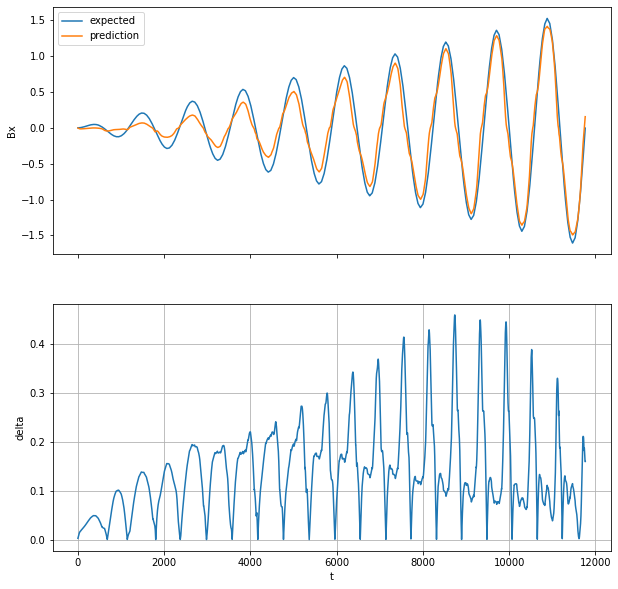

MSE: 0.02740044243362149


In [ ]:
model = tf.keras.models.load_model('./Model_GRU1_M6')
pred = inference_loop(model, M6_test_X)
del model

plot_predictions(pred, M6_test_Y, figsize=(10, 10))

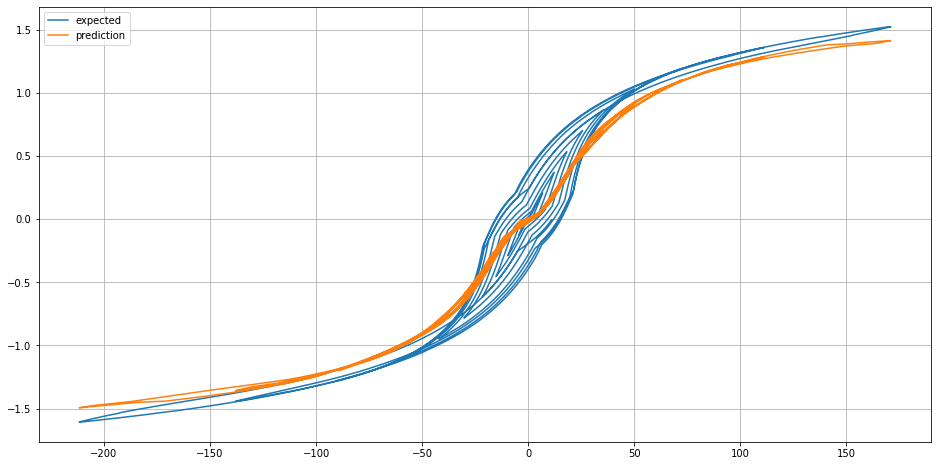

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(M6_test_X[:, -1, 0], M6_test_Y, label='expected')
plt.plot(M6_test_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

### M19

Epoch 1/1000
56/56 [==============================] - 5s 27ms/step - loss: 0.2352
Epoch 2/1000
56/56 [==============================] - 2s 28ms/step - loss: 0.0231
Epoch 3/1000
56/56 [==============================] - 2s 27ms/step - loss: 0.0118
Epoch 4/1000
56/56 [==============================] - 2s 27ms/step - loss: 0.0075
Epoch 5/1000
56/56 [==============================] - 2s 27ms/step - loss: 0.0050
Epoch 6/1000
56/56 [==============================] - 2s 27ms/step - loss: 0.0037
Epoch 7/1000
56/56 [==============================] - 2s 27ms/step - loss: 0.0033
Epoch 8/1000
56/56 [==============================] - 2s 27ms/step - loss: 0.0027
Epoch 9/1000
56/56 [==============================] - 2s 27ms/step - loss: 0.0023
Epoch 10/1000
56/56 [==============================] - 2s 28ms/step - loss: 0.0023
Epoch 11/1000
56/56 [==============================] - 2s 27ms/step - loss: 0.0022
Epoch 12/1000
56/56 [==============================] - 2s 28ms/step - loss: 0.0017
Epoch 13/1000

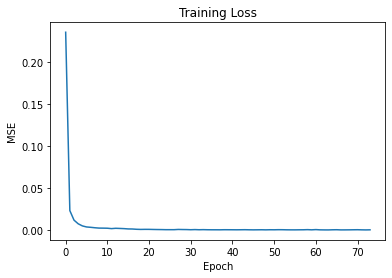

In [ ]:
model = new_model_gru1()
history = compile_and_fit(model, M19_train_X, M19_train_Y)
model.save('./Model_GRU1_M19')
plot_train_stats(history)
del model, history

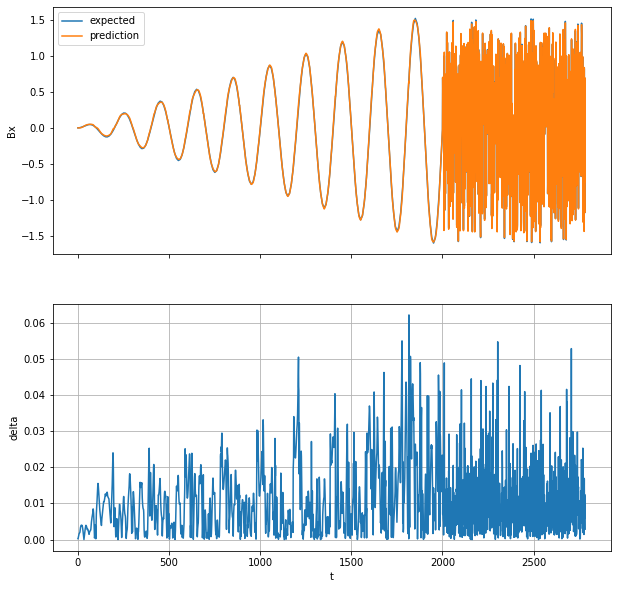

MSE: 0.0002024274798815394


In [ ]:
model = tf.keras.models.load_model('./Model_GRU1_M19')
pred = model.predict(M19_train_X)
del model

plot_predictions(pred, M19_train_Y, figsize=(10, 10))

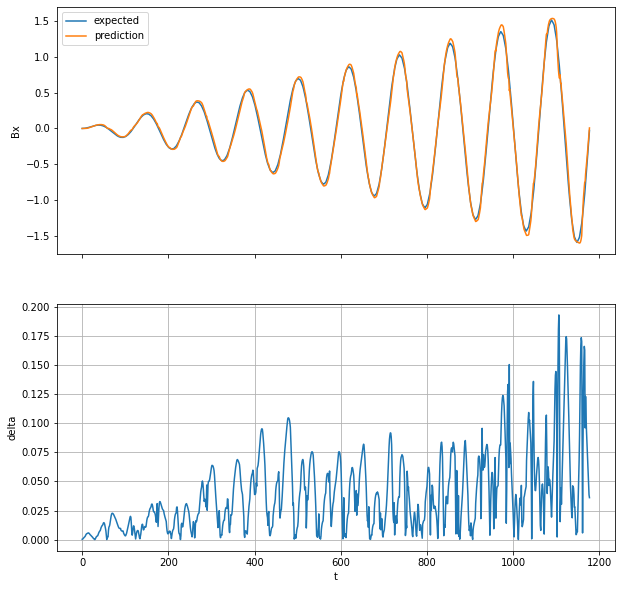

MSE: 0.0026256416045708822


In [ ]:
model = tf.keras.models.load_model('./Model_GRU1_M19')
pred = model.predict(M19_test_X)
del model

plot_predictions(pred, M19_test_Y, figsize=(10, 10))

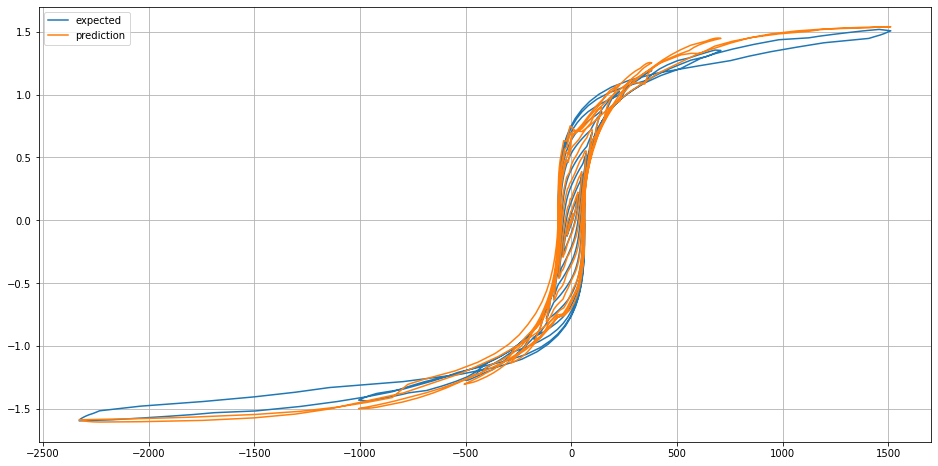

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(M19_test_X[:, -1, 0], M19_test_Y, label='expected')
plt.plot(M19_test_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

Start inference loop on 1178 samples... DONE after 56.59700536727905s


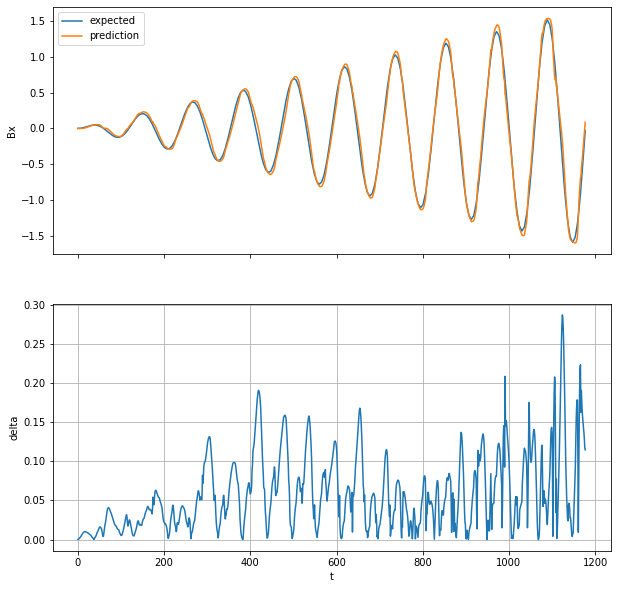

MSE: 0.005754500987067573


In [ ]:
model = tf.keras.models.load_model('./Model_GRU1_M19')
pred = inference_loop(model, M19_test_X)
del model

plot_predictions(pred, M19_test_Y, figsize=(10, 10))

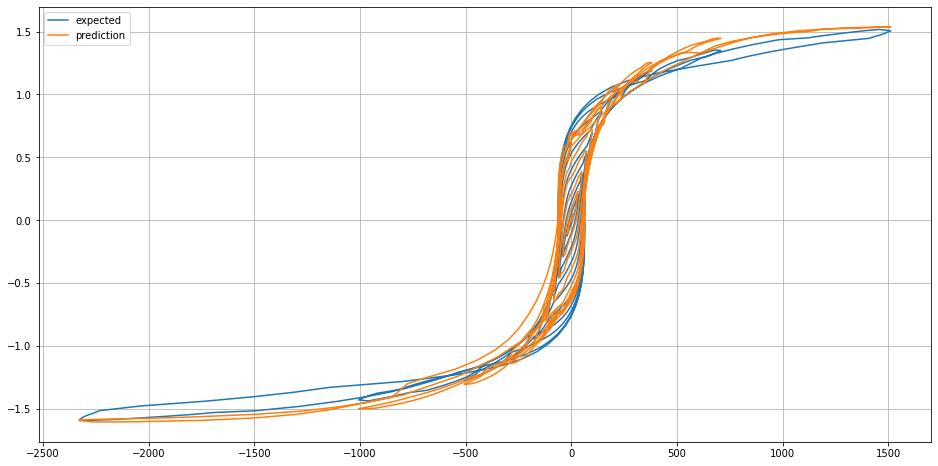

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(M19_test_X[:, -1, 0], M19_test_Y, label='expected')
plt.plot(M19_test_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

### M27

Epoch 1/1000
56/56 [==============================] - 5s 28ms/step - loss: 0.2304
Epoch 2/1000
56/56 [==============================] - 2s 28ms/step - loss: 0.0288
Epoch 3/1000
56/56 [==============================] - 2s 29ms/step - loss: 0.0137
Epoch 4/1000
56/56 [==============================] - 2s 28ms/step - loss: 0.0071
Epoch 5/1000
56/56 [==============================] - 2s 27ms/step - loss: 0.0051
Epoch 6/1000
56/56 [==============================] - 2s 28ms/step - loss: 0.0037
Epoch 7/1000
56/56 [==============================] - 2s 28ms/step - loss: 0.0031
Epoch 8/1000
56/56 [==============================] - 2s 28ms/step - loss: 0.0027
Epoch 9/1000
56/56 [==============================] - 2s 27ms/step - loss: 0.0023
Epoch 10/1000
56/56 [==============================] - 2s 28ms/step - loss: 0.0020
Epoch 11/1000
56/56 [==============================] - 2s 28ms/step - loss: 0.0017
Epoch 12/1000
56/56 [==============================] - 2s 28ms/step - loss: 0.0016
Epoch 13/1000

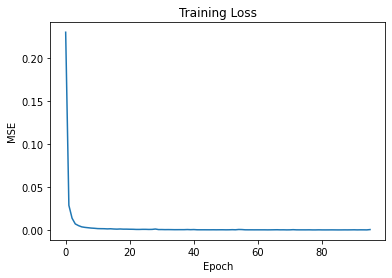

In [ ]:
model = new_model_gru1()
history = compile_and_fit(model, M27_train_X, M27_train_Y)
model.save('./Model_GRU1_M27')
plot_train_stats(history)
del model, history

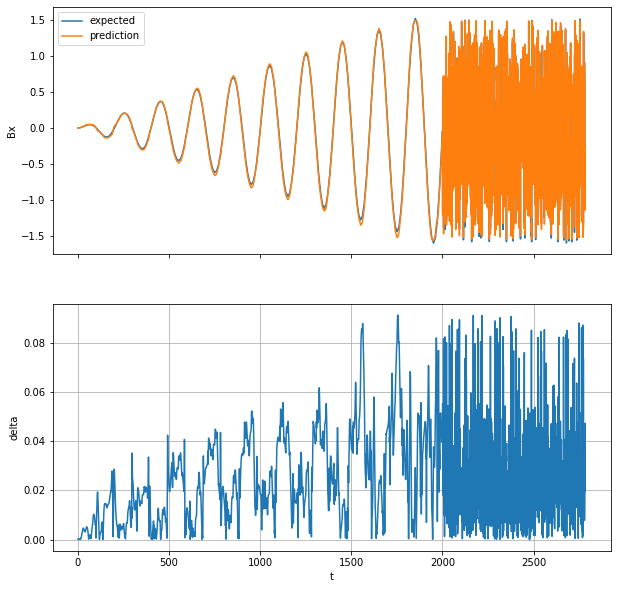

MSE: 0.0009996357497467124


In [ ]:
model = tf.keras.models.load_model('./Model_GRU1_M27')
pred = model.predict(M27_train_X)
del model

plot_predictions(pred, M27_train_Y, figsize=(10, 10))

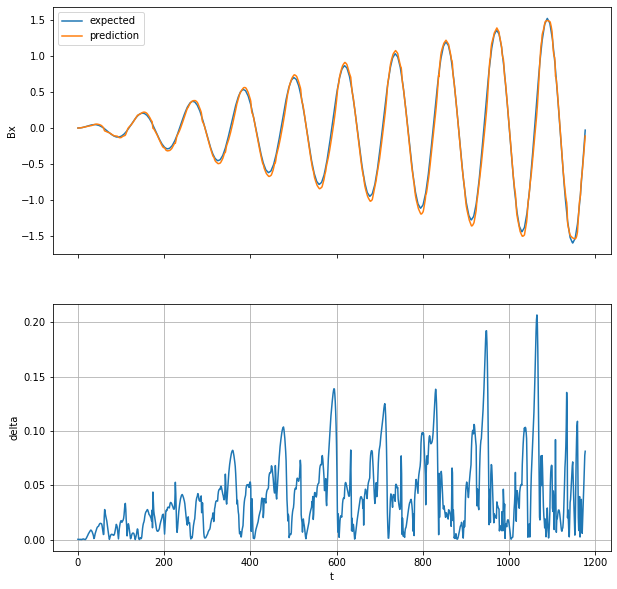

MSE: 0.002790373436812007


In [ ]:
model = tf.keras.models.load_model('./Model_GRU1_M27')
pred = model.predict(M27_test_X)
del model

plot_predictions(pred, M27_test_Y, figsize=(10, 10))

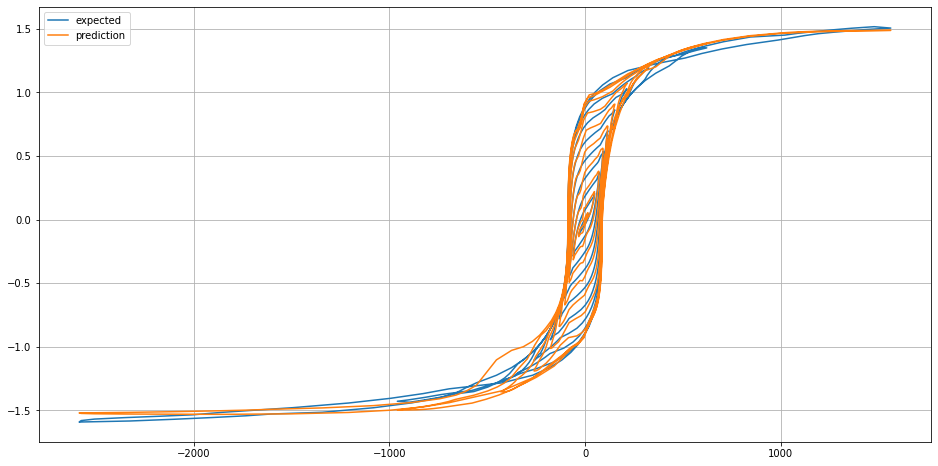

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(M27_test_X[:, -1, 0], M27_test_Y, label='expected')
plt.plot(M27_test_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

Start inference loop on 1178 samples... DONE after 57.00013828277588s


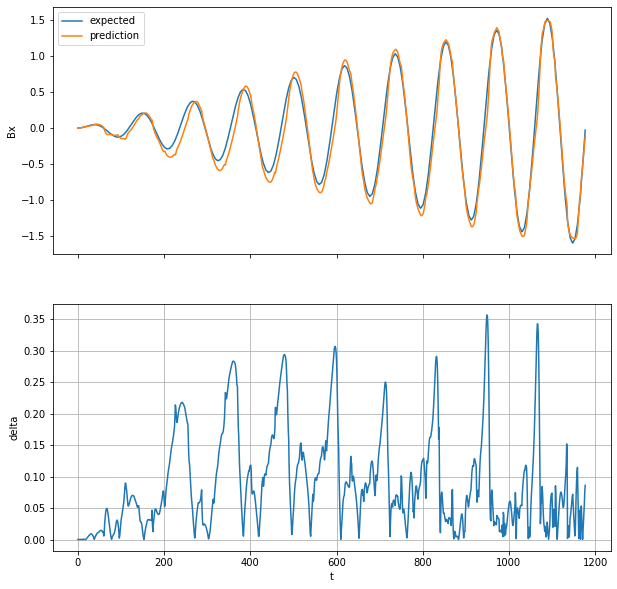

MSE: 0.014408875348765098


In [ ]:
model = tf.keras.models.load_model('./Model_GRU1_M27')
pred = inference_loop(model, M27_test_X)
del model

plot_predictions(pred, M27_test_Y, figsize=(10, 10))

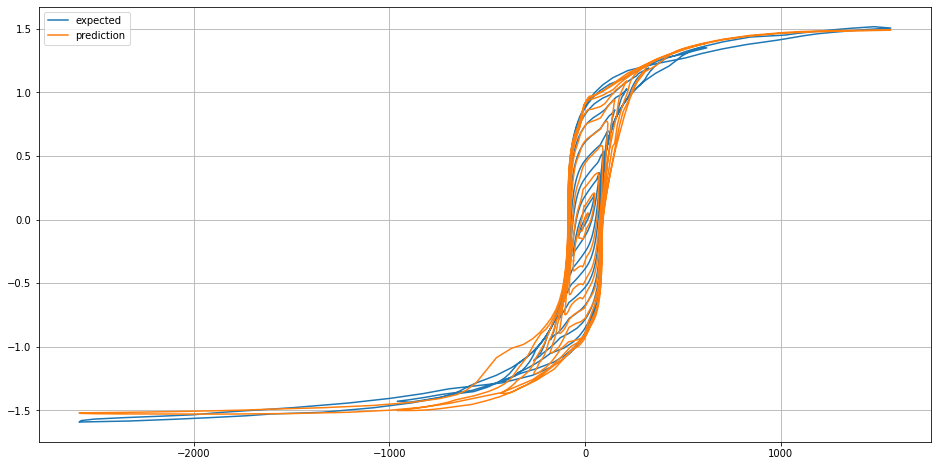

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(M27_test_X[:, -1, 0], M27_test_Y, label='expected')
plt.plot(M27_test_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

### 20PNF1500

Epoch 1/1000
56/56 [==============================] - 5s 28ms/step - loss: 0.2266
Epoch 2/1000
56/56 [==============================] - 2s 28ms/step - loss: 0.0202
Epoch 3/1000
56/56 [==============================] - 2s 28ms/step - loss: 0.0127
Epoch 4/1000
56/56 [==============================] - 2s 28ms/step - loss: 0.0094
Epoch 5/1000
56/56 [==============================] - 2s 28ms/step - loss: 0.0065
Epoch 6/1000
56/56 [==============================] - 2s 29ms/step - loss: 0.0043
Epoch 7/1000
56/56 [==============================] - 2s 29ms/step - loss: 0.0034
Epoch 8/1000
56/56 [==============================] - 2s 28ms/step - loss: 0.0027
Epoch 9/1000
56/56 [==============================] - 2s 28ms/step - loss: 0.0022
Epoch 10/1000
56/56 [==============================] - 2s 28ms/step - loss: 0.0019
Epoch 11/1000
56/56 [==============================] - 2s 28ms/step - loss: 0.0016
Epoch 12/1000
56/56 [==============================] - 2s 27ms/step - loss: 0.0014
Epoch 13/1000

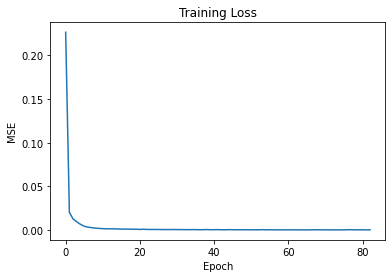

In [ ]:
model = new_model_gru1()
history = compile_and_fit(model, _20PNF1500_train_X, _20PNF1500_train_Y)
model.save('./Model_GRU1__20PNF1500')
plot_train_stats(history)
del model, history

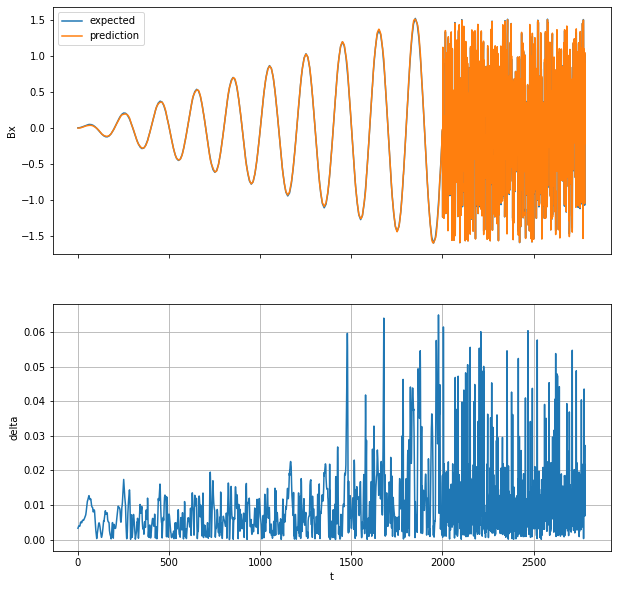

MSE: 0.00018087125070480892


In [ ]:
model = tf.keras.models.load_model('./Model_GRU1__20PNF1500')
pred = model.predict(_20PNF1500_train_X)
del model

plot_predictions(pred, _20PNF1500_train_Y, figsize=(10, 10))

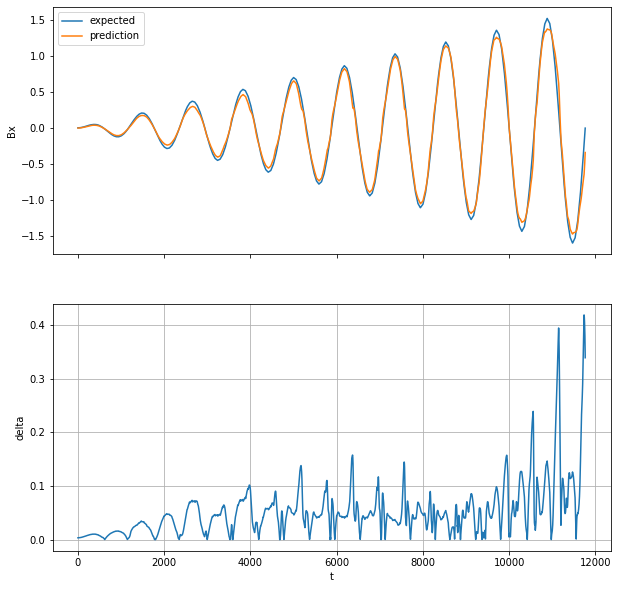

MSE: 0.005149529291477375


In [ ]:
model = tf.keras.models.load_model('./Model_GRU1__20PNF1500')
pred = model.predict(_20PNF1500_test_X)
del model

plot_predictions(pred, _20PNF1500_test_Y, figsize=(10, 10))

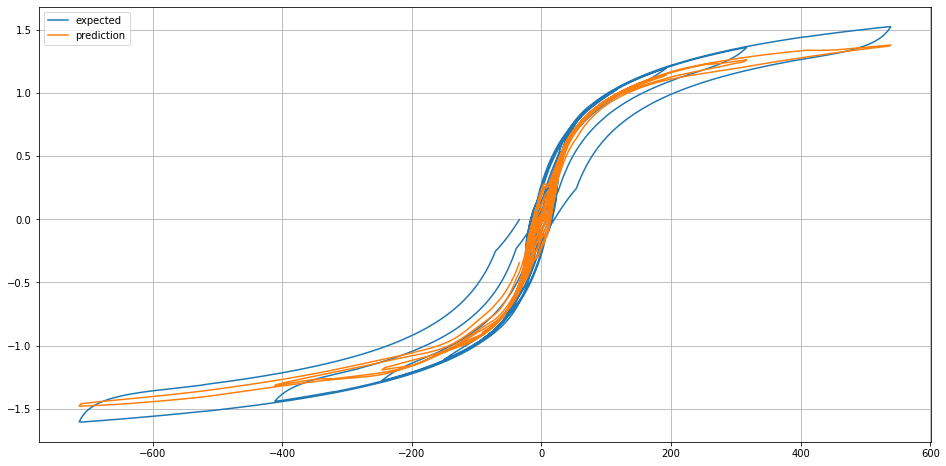

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(_20PNF1500_test_X[:, -1, 0], _20PNF1500_test_Y, label='expected')
plt.plot(_20PNF1500_test_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

Start inference loop on 11766 samples... DONE after 576.4152021408081s


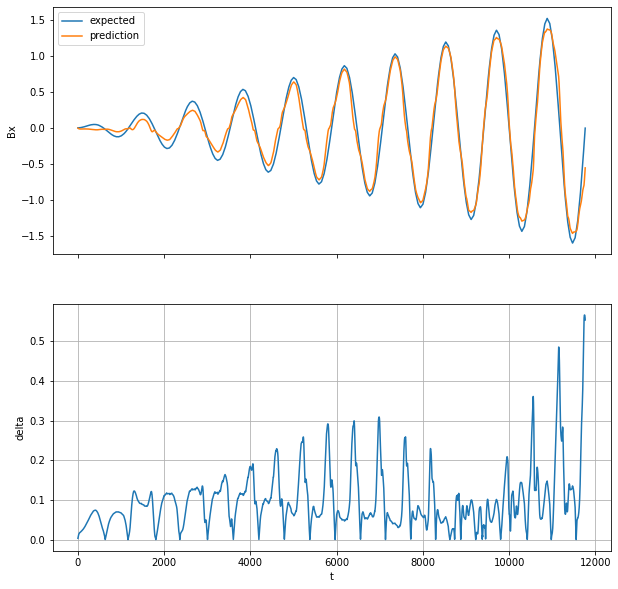

MSE: 0.01477477651179284


In [ ]:
model = tf.keras.models.load_model('./Model_GRU1__20PNF1500')
pred = inference_loop(model, _20PNF1500_test_X)
del model

plot_predictions(pred, _20PNF1500_test_Y, figsize=(10, 10))

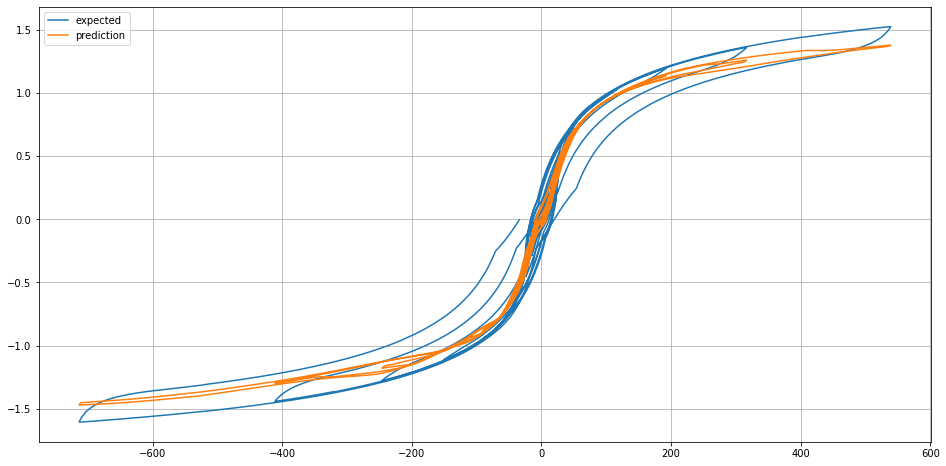

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(_20PNF1500_test_X[:, -1, 0], _20PNF1500_test_Y, label='expected')
plt.plot(_20PNF1500_test_X[:, -1, 0], pred, label='prediction')
plt.grid()
plt.legend()
plt.show()

# The End